In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import reduce
from copy import deepcopy

BASE_DIR = './dataset/'
# BASE_DIR = './'
PAPER_AUT = 'paper_author_relationship.csv'

# BASE_DIR = './'
PAPER_AUT = 'paper_author_relationship.csv'
TRAIN_SET = 'train_dataset.csv'
VALID_SET = 'valid_dataset.csv'
QQ_SET = '../query_dataset_labels.csv'
QUERY_SET = 'query_dataset.csv'

SAME_VALID = 'valid_same_author.csv'
SAME_TEST = 'same_author.csv'


In [3]:
def get_paper_author():
    a2p = {}
    p2a = {}
    lines = open(os.path.join(BASE_DIR, PAPER_AUT), "r")
    
    for paper, authors in enumerate(lines.readlines()):
        authors = authors.replace('\n', '').split(',')
        p2a[paper] = []
        for author_id in authors:
            author_id = int(author_id)
            p2a[paper].append(author_id)
            if author_id not in a2p:
                a2p[author_id] = []
            a2p[author_id].append(paper)
    return a2p, p2a

def get_train():
    same = []
    same_authors = open(os.path.join(BASE_DIR, TRAIN_SET), 'r')
    for i, same_authors in enumerate(same_authors.readlines()):
        if i > 0:
            same_authors = same_authors.replace('\n', '').replace(' ', '').split(',')
            same.append([int(same_authors[0]), int(same_authors[1])])
            same.append([int(same_authors[1]), int(same_authors[0])])
    return same

def get_test():
    same = []
    same_authors = open(os.path.join(BASE_DIR, QUERY_SET), 'r')
    for i, same_authors in enumerate(same_authors.readlines()):
        if i > 0:
            same_authors = same_authors.replace('\n', '').replace(' ', '').split(',')
            same.append([int(same_authors[0]), int(same_authors[1])])
            # same[int(same_authors[1])] = int(same_authors[0])
    return same

def get_qq():
    same = {}
    same_authors = open(os.path.join(BASE_DIR, QQ_SET), 'r')
    for i, same_authors in enumerate(same_authors.readlines()):
        if i > 0:
            a1, a2, a3 = same_authors.replace('\n', '').replace(' ', '').split(',')
            a1, a2, a3 = int(a1), int(a2), False if a3 == 'False' else True  
            same[(a1, a2) if a1 < a2 else (a2, a1)] = a3
            # same[int(same_authors[1])] = int(same_authors[0])
    return same

def get_valid():
    same = {}
    same_authors = open(os.path.join(BASE_DIR, VALID_SET), 'r')
    for i, same_authors in enumerate(same_authors.readlines()):
        if i > 0:
            a1, a2, a3 = same_authors.replace('\n', '').replace(' ', '').split(',')
            a1, a2, a3 = int(a1), int(a2), False if a3 == 'False' else True  
            same[(a1, a2) if a1 < a2 else (a2, a1)] = a3
            # same[int(same_authors[1])] = int(same_authors[0])
    return same

def get_same():
    same = {}
    same_authors = open(os.path.join(BASE_DIR, TRAIN_SET), 'r')
    for i, same_authors in enumerate(same_authors.readlines()):
        if i > 0:
            same_authors = same_authors.replace('\n', '').replace(' ', '').split(',')
            same[int(same_authors[0])] = int(same_authors[1])
            same[int(same_authors[1])] = int(same_authors[0])
    return same

In [4]:
def get_author():
    same = {}
    same_authors = open(os.path.join(BASE_DIR, VALID_SET), 'r')
    for i, same_authors in enumerate(same_authors.readlines()):
        if i > 0:
            same_authors = same_authors.replace('\n', '').replace(' ', '').split(',')
            same[int(same_authors[0])] = int(same_authors[1])
            same[int(same_authors[1])] = int(same_authors[0])
    return same

In [5]:
def show_histogram(data, bins='auto', unique=True, xl='', yl='', title='', xlog=False, ylog=False):
    plt.figure(figsize=(8,5))
    if unique:
        hist = [len(np.unique(v)) for v in data.values()]
    else:  
        hist = [len(v) for v in data.values()]
    print('MIN MAX MEDIAN MEAN STD LEN')
    print(min(hist), max(hist), np.median(hist), np.mean(hist), np.std(hist), len(hist))
    _ = plt.hist(hist, bins=bins)  # arguments are passed to np.histogram
    plt.title(title)
    plt.xlabel(xl)
    plt.ylabel(yl)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.show()

def histogram(hist, bins='auto', unique=True):
    if len(hist):
        print('MIN MAX MEDIAN MEAN STD LEN')
        print(min(hist), max(hist), np.median(hist), np.mean(hist), np.std(hist), len(hist))
        _ = plt.hist(hist, bins=bins)  # arguments are passed to np.histogram
        plt.title("Histogram with {} bins".format(bins))
        plt.show()

In [6]:
author2paper, paper2author = get_paper_author()
same = get_same()
valid_set = get_valid()
qq_set = get_qq()
train_set = get_train()
test_set = get_test()

In [7]:
for k, v in same.items():
    if k in author2paper and v in author2paper:
        l1 = set(author2paper[k])
        l2 = set(author2paper[v])
        if len(l1.intersection(l2)):
            print('gotcha')

In [8]:
author2authors = {}
for a, pl in author2paper.items():
    author2authors[a] = []
    for p in pl:
        for aut in paper2author[p]:
            if aut != a:
                author2authors[a].append(aut)

In [9]:
a2a = {}
def get_them(root, max_level):
    seen_paper = {}
    seen_author = {}
    _get_authors(root, root, 1, max_level, seen_author, seen_paper)

def _get_authors(root, node, level, max_level, seen_author, seen_paper):
    aa = []
    if level >= max_level:
        return
    if node in author2paper:
        for p in author2paper[node]:
            if p not in seen_paper:
                seen_paper[p] = True
                for a in paper2author[p]:
                    if a != node:
                        if root not in a2a:
                            a2a[root] = {}
                        if a not in a2a[root]:
                            a2a[root][a] = {}
                        if level not in a2a[root][a]:
                            a2a[root][a][level] = 0 
                        a2a[root][a][level] += 1
                        if a not in seen_author:
                            aa.append(a)
                        seen_author[a] = True

    for a in aa:
        _get_authors(root, a, level+1, max_level, seen_author, seen_paper)


In [10]:
same_without_connections = []
same_with_connections = []
for s1, s2 in same.items():
    if s1 in a2a and s2 in a2a[s1]:
        print(s1, s2, a2a[s1][s2])
        same_with_connections.append((s1,s2))
    else:
        same_without_connections.append((s1,s2))
print(len(same_without_connections), len(same_with_connections))

2000 0


MIN MAX MEDIAN MEAN STD LEN
1 2294 6.0 18.58835975391426 44.372729350040444 61442


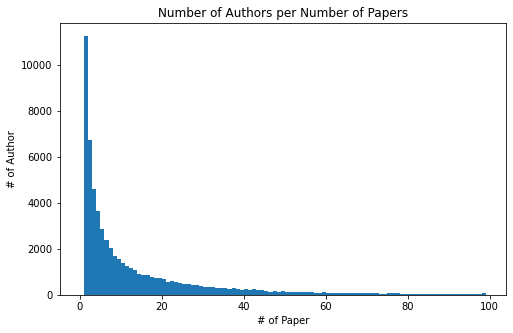

In [11]:
show_histogram(author2paper, range(100), xl='# of Paper', yl='# of Author', title='Number of Authors per Number of Papers')

MIN MAX MEDIAN MEAN STD LEN
2 132 2.0 2.5436319336489936 2.606612261881853 449006


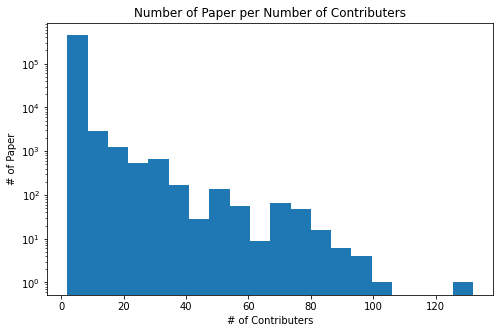

In [12]:
show_histogram(paper2author, 'auto', ylog=True, xl='# of Contributers', yl='# of Paper', title='Number of Paper per Number of Contributers')

MIN MAX MEDIAN MEAN STD LEN
1 977 4.0 13.317502685459457 34.874318084705 61442


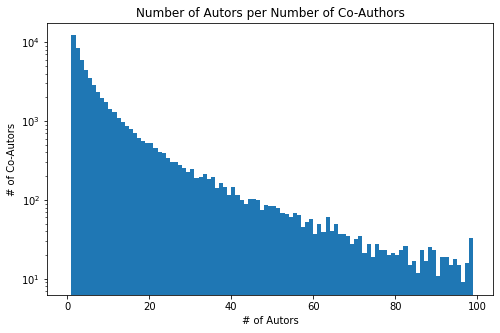

In [13]:
show_histogram(author2authors, range(100), ylog=True, xl='# of Autors', yl='# of Co-Autors', title='Number of Autors per Number of Co-Authors')

In [14]:
from tqdm import tqdm

In [15]:
hey = {}
for k, v in tqdm(same.items()):
    pk = author2paper[k]
    pv = author2paper[v]
    co1 = []
    co2 = []
    for p in pk:
        co1 += [a for a in paper2author[p] if a != k]
    for p in pv:
        co2 += [a for a in paper2author[p] if a != v]
    hey[(k,v)] = set(co1).intersection(set(co2))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 5505.35it/s]


MIN MAX MEDIAN MEAN STD LEN
1 452 13.0 32.018 56.763154211160604 2000


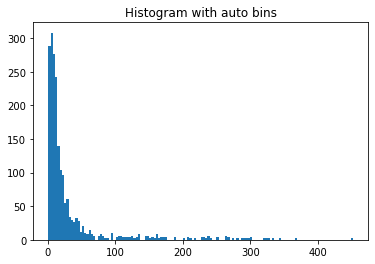

In [16]:
hey1 = [len(v) for v in hey.values()]
histogram(hey1)

In [17]:
hey2 = []
for a,v in author2authors.items():
    vp = [v for v in v if (a,v) not in same]
    hey2.append(len(set(v)))

MIN MAX MEDIAN MEAN STD LEN
1 977 4.0 13.317502685459457 34.874318084705 61442


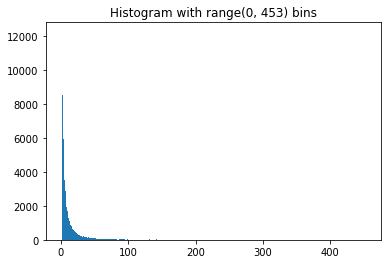

In [18]:
histogram(hey2, range(453))

In [19]:
from scipy.special import comb
r = []
for x in range(1,1000):
    p_a = len(same) / comb(len(author2paper), 2)
    p_b = len([h for h in hey2 if h == x]) / comb(len(author2paper), 2)
    p_b_a = len([h for h in hey1 if h == x]) / comb(len(same), 2)
    p_a_b = p_b_a * p_a / p_b if p_b > 0 else 0
    r.append(p_a_b)

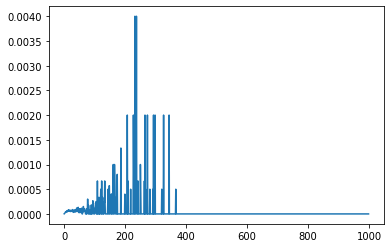

In [20]:
plt.plot(r)

MIN MAX MEDIAN MEAN STD LEN
0.0 0.00400200100050025 0.0 5.566847426172557e-05 0.00027834310327423645 999


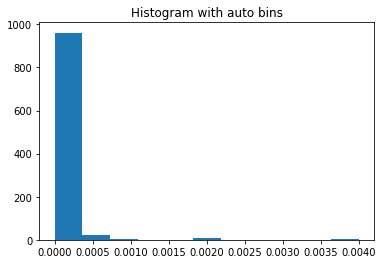

In [21]:
histogram(r)

## Evaluate

In [22]:
def random_model(a1, a2, th):
  if a1 in author2authors and (a2 not in author2authors[a1]) and np.random.rand() < th:
  # if np.random.rand() < th:
    return True
  return False

In [23]:
def coaut_model(a1, a2, th):
  if a1 in author2authors and a2 in author2authors:
    c1 = author2authors[a1]
    c2 = author2authors[a2]
    cc = set(c1).intersection(set(c2))
    if len(cc) > (1 - th) * 10:
      return True
  
  
  return random_model(a1, a2, th)

def coaut_model2(a1, a2, th):
  if a1 in author2authors and a2 in author2authors:
    c1 = author2authors[a1]
    c2 = author2authors[a2]
    cc = set(c1).intersection(set(c2))
    return random_model(a1, a2, th * len(cc))

  return random_model(a1, a2, th)


def coaut_model3(a1, a2, th):
  if a1 in author2authors and a2 in author2authors:
    c1 = author2authors[a1]
    c2 = author2authors[a2]
    cc = set(c1).intersection(set(c2))
    return random_model(a1, a2, th * np.log(len(cc)))

  return random_model(a1, a2, th)

def coaut_model4(a1, a2, th):
  if a1 in author2authors and a2 in author2authors:
    c1 = author2authors[a1]
    c2 = author2authors[a2]
    cc = set(c1).intersection(set(c2))
    return random_model(a1, a2, th * (-0.5 + np.log(len(cc))))

  return random_model(a1, a2, th)


In [24]:
dfs = []
def center_model(a1, a2, th):
  if a1 in author2paper and a2 in author2paper:
    p1 = len(author2paper[a1])
    p2 = len(author2paper[a2])
    df = np.abs(p1 - p2)
    if df > 6:
      return True

  return random_model(a1, a2, th)

In [25]:
# plot_one(qq_set, center_model)

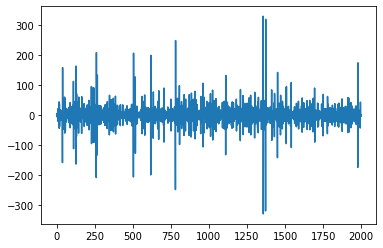

MIN MAX MEDIAN MEAN STD LEN
-329 329 0.0 0.0 33.61478841224499 2000


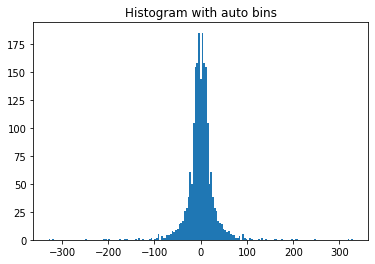

In [26]:
x = []
z = []
for a in train_set:
  x.append(len(author2paper[a[0]]))
  z.append(len(author2paper[a[1]]) - len(author2paper[a[0]]))

# plt.plot(x)
plt.plot(z)
plt.show()
histogram(z)

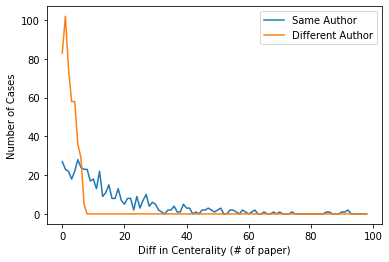

In [27]:
x = [0 for _ in range(1000)]
z = [0 for _ in range(1000)]
  
for k, v in valid_set.items():
  p1 = len(author2paper[k[0]])
  p2 = len(author2paper[k[1]])
  l = np.abs(p1 - p2)
  if v:
    x[l] += 1
  else:
    z[l] += 1

kf = 100
kl = 1
plt.plot(x[kl:kf], label='Same Author')
plt.plot(z[kl:kf], label='Different Author')
# plt.plot([z[i] / (x[i] + 0.0001) for i in range(kl, kf)], label='D')
# plt.plot([np.log(i) for i in range(kl,kf)], label='L')
plt.legend()
plt.xlabel('Diff in Centerality (# of paper)')
plt.ylabel('Number of Cases')
plt.show()  

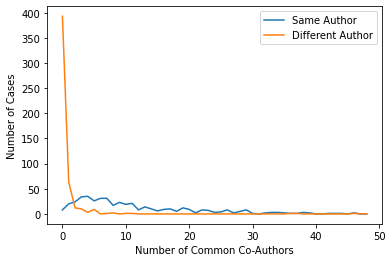

In [28]:
x = [0 for _ in range(1000)]
z = [0 for _ in range(1000)]
  
for k, v in valid_set.items():
  c1 = author2authors[k[0]]
  c2 = author2authors[k[1]]
  cc = set(c1).intersection(set(c2))
  l = len(cc)
  if k[1] in c1:
    print('asdf')
  if v:
    x[l] += 1
  else:
    z[l] += 1

kf = 50
kl = 1
plt.plot(x[kl:kf], label='Same Author')
plt.plot(z[kl:kf], label='Different Author')
# plt.plot([z[i] / (x[i] + 0.0001) for i in range(kl, kf)], label='D')
# plt.plot([np.log(i) for i in range(kl,kf)], label='L')
plt.legend()
plt.xlabel('Number of Common Co-Authors')
plt.ylabel('Number of Cases')
plt.show()  

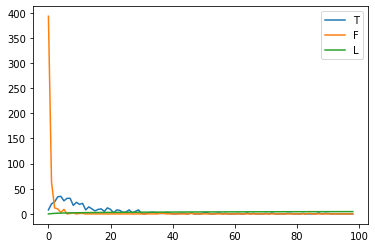

In [29]:
x = [0 for _ in range(1000)]
z = [0 for _ in range(1000)]
  
for k, v in valid_set.items():
  c1 = author2authors[k[0]]
  c2 = author2authors[k[1]]
  cc = set(c1).intersection(set(c2))
  l = len(cc)
  if k[1] in c1:
    print('asdf')
  if v:
    x[l] += 1
  else:
    z[l] += 1

kf = 100
kl = 1
plt.plot(x[kl:kf], label='T')
plt.plot(z[kl:kf], label='F')
# plt.plot([z[i] / (x[i] + 0.0001) for i in range(kl, kf)], label='D')
plt.plot([np.log(i) for i in range(kl,kf)], label='L')
plt.legend()
plt.show()  

In [30]:
def evaluate(valid, model, th):
  TP, TN, FP, FN = 0, 0, 0, 0
  for (a1, a2), t in valid.items():
    p = model(a1, a2, th)
    if p == t and t:
      TP += 1
      # print(a1, a2)
    elif p == t and not t:
      TN += 1
    elif p != t and not t:
      FP += 1
    elif p != t and t:
      FN += 1
    else:
      print('wtf')
  # if 0 in [TP, TN, FP, FN]:
  #   print([TP, TN, FP, FN])
  acc = (TP + TN) / (TP + TN + FP + FN)
  pre = (TP / (TP + FP)) if TP + FP != 0 else 1
  rec = (TP / (TP + FN)) if TP + FN != 0 else 1
  f1s = (2*TP / (2*TP + FP + FN)) if 2*TP + FP + FN != 0 else 1
  # print(TP, TN, FP, FN)
  # print('Acc: {}'.format(acc))
  # print('Pre: {}'.format(pre))
  # print('Rec: {}'.format(rec))
  # print('F1S: {}'.format(f1s))
  return f1s, acc, pre, rec
evaluate(valid_set, random_model, 1)

(0.6666666666666666, 0.5, 0.5, 1.0)

In [31]:
def plot_all(valid, models, names):

  for n in ['Recall', 'Accuracy', 'Precision', 'F1-Score']:
    for model, name in zip(models, names):
      f1 = []
      ac = []
      pr = []
      re = []
      for i in range(1,101):
        f, a, p, r = evaluate(valid, model, i / 100.0)
        f1.append(f)
        ac.append(a)
        pr.append(p)
        re.append(r)
      j = {
          'Recall': re,
          'Accuracy': ac,
          'Precision': pr,
          'F1-Score': f1
      }
      plt.plot(j[n], label=name)
      # plt.plot(ac, label='Accuracy')
      # plt.plot(pr, label='Precision')
      # plt.plot(re, label='Recall')
    plt.ylabel(n)
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()
    # print(max(f1), np.argmax(f1))
    # print(max(ac), np.argmax(ac))

def plot_one(valid, model):
  f1 = []
  ac = []
  pr = []
  re = []
  for i in range(1,101):
    f, a, p, r = evaluate(valid, model, i / 100.0)
    f1.append(f)
    ac.append(a)
    pr.append(p)
    re.append(r)
  plt.plot(f1, label='F1 Score')
  plt.plot(ac, label='Accuracy')
  plt.plot(pr, label='Precision')
  plt.plot(re, label='Recall')
  plt.legend()
  plt.show()
  print(max(f1), np.argmax(f1))
  print(max(ac), np.argmax(ac))

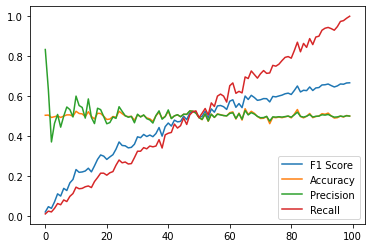

0.6666666666666666 99
0.537 65


In [32]:
plot_one(qq_set, random_model)

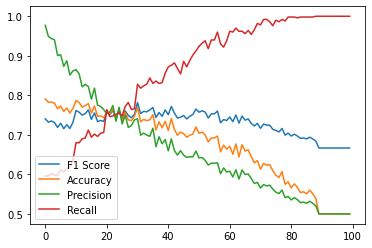

0.7818696883852692 30
0.791 0


In [33]:
plot_one(qq_set, coaut_model)

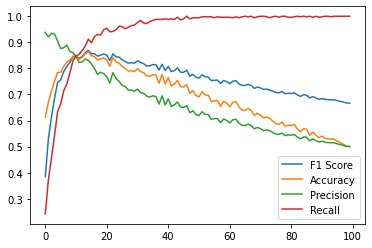

0.8693994280266921 14
0.863 14


In [34]:
plot_one(qq_set, coaut_model2)

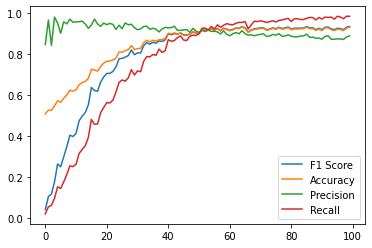

0.9338446788111218 85
0.932 64


In [35]:
plot_one(qq_set, coaut_model3)

In [36]:
# plot_all(valid2_set, [random_model, coaut_model2, coaut_model3, center_model, gnn_model], ['Random', 'Co-Author [Liner]', 'Co-Author [Log]', 'Centrality [Hard]', 'GNN'])

## MODEL

In [37]:
import networkx as nx

In [38]:
to_aut = lambda x: 'a_'+str(x)
to_pap = lambda x: 'p_'+str(x)

In [39]:
es = []
for a, ps in author2paper.items():
  es += [['a_'+str(a), 'p_'+str(p)] for p in ps]

In [40]:
g = nx.Graph()
g.add_edges_from(es)

In [41]:
for node in tqdm(g.nodes()):
  nbs_degree = [g.degree[nb] for nb in g.adj[node]]
  g.nodes[node]['feat'] = [g.degree[node], np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510448/510448 [00:38<00:00, 13193.46it/s]


In [42]:
for i, n in enumerate(g.nodes(data=True)):
  print(n)
  if i > 10:
    break

('a_2098387', {'feat': [6, 2, 2, 2.0, 0.0]})
('p_0', {'feat': [2, 6, 11, 8.5, 2.5]})
('p_73389', {'feat': [2, 6, 11, 8.5, 2.5]})
('p_191080', {'feat': [2, 6, 11, 8.5, 2.5]})
('p_256623', {'feat': [2, 6, 11, 8.5, 2.5]})
('p_347517', {'feat': [2, 6, 11, 8.5, 2.5]})
('p_373236', {'feat': [2, 6, 11, 8.5, 2.5]})
('a_954495', {'feat': [11, 2, 2, 2.0, 0.0]})
('p_12452', {'feat': [2, 1, 11, 6.0, 5.0]})
('p_228121', {'feat': [2, 11, 649, 330.0, 319.0]})
('p_289437', {'feat': [2, 11, 19, 15.0, 4.0]})
('p_298170', {'feat': [2, 2, 11, 6.5, 4.5]})


In [43]:
def get_subgraph(a1, a2, cutoff=3):
  p = {}
  b1, b2 = [], []
  [b1.extend([a for a in paper2author[p] if a != a1]) for p in author2paper[a1]]
  [b2.extend([a for a in paper2author[p] if a != a2]) for p in author2paper[a2]]
  b3 = set(b1).intersection(set(b2))
  p3 = []
  [p3.extend(author2paper[b]) for b in b3]
  p1 = [to_pap(p) for p in author2paper[a1] if p in p3]
  p2 = [to_pap(p) for p in author2paper[a2] if p in p3]
  b3 = [to_aut(b) for b in b3]
  all_node = [to_aut(a1)] + [to_aut(a2)] + b3 + p1 + p2
  return set(all_node), to_aut(a1), to_aut(a2), list(set(p1)), list(set(p2)), list(set(b3))

In [212]:
COLORS = [
    'tab:red',
    'tab:blue',
    'tab:green',
    'tab:purple',
    'tab:pink',
    'tab:cyan',
]
def draw(graph, a1, a2, p1, p2, b3, edge_l=[], edge_w=[]):
  # print(len(graph.nodes()), 2+len(p1)+len(p2)+len(b3))
  pos = {}
  j = 0
  for n in graph.nodes():
    if n == 'reduce_0':
      pos[n] = [-0.9, -2]
    elif n == 'reduce_1':
      pos[n] = [0.9, -2]
    elif n == a1:
      pos[n] = [-1, 0]
    elif n == a2:
      pos[n] = [1, 0]
    elif n in p1 and n in p2:
        pos[n] = [((-1)**j)*((j+1)//2/10), 4]
        j += 1
    elif n in p1:
      pos[n] = [-0.5, 2*p1.index(n)/len(p1) - 1]
    elif n in p2:
      pos[n] = [0.5, 2*p2.index(n)/len(p2) - 1]
    else:
      pos[n] = [0.0, 2*b3.index(n)/len(b3) - 1]
  options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
  nx.draw_networkx_nodes(graph, pos, nodelist=[c for c in graph.nodes() if c.startswith('a')], node_color=COLORS[0], **options)
  nx.draw_networkx_nodes(graph, pos, nodelist=[c for c in graph.nodes() if c.startswith('p')], node_color=COLORS[1], **options)
  nx.draw_networkx_nodes(graph, pos, nodelist=[c for c in graph.nodes() if c.startswith('reduce')], node_color=COLORS[2], **options)
  # nx.draw_networkx_nodes(G, pos, nodelist=[4, 5, 6, 7], node_color="tab:blue", **options)

  # edges
  if len(edge_l) and len(edge_w):
    [nx.draw_networkx_edges(graph, pos,edgelist=[e], width=w, alpha=0.5) for e, w in zip(edge_l, edge_w)]
  else:
    nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)

  # some math labels
  labels = {c:('A' if c == a1 else ('B' if c == a2 else '')) for c in graph.nodes()}
  nx.draw_networkx_labels(graph, pos, labels, font_size=22, font_color="black")
  plt.tight_layout()
  plt.axis("off")
  plt.show()

In [106]:
for a1, a2 in train_set:
    print(a1, a2)
    break

1483127 2059226


In [136]:
def get_neg_candidate(same_author):
    # NOT IN TRAINIG, NOT CO-AUTHOR, HAVING SAME CO-AUTHROS
    authros2candidate = {}
    all_candidate = 0
    positive = 0
    for a1, a2 in tqdm(same_author):
        ps = author2paper[a1]
        coaut = {}
        for p in ps:
            for aut in paper2author[p]:
                if aut in [a1, a2]:
                    continue
                if aut not in coaut:
                    coaut[aut] = 0
                coaut[aut] += 1
        coa = coaut.keys()
        if len(coa) == 0:
            continue
#         print(coa)
        papers = []
        [papers.extend(author2paper[aut]) for aut in coa]
        papers = [p for p in set(papers) if p not in ps]
        authors = {}
    #     print(papers)
        for p in papers:
            for aut in paper2author[p]:
                if aut in coa:
                    continue
                if aut in [a1, a2]:
                    continue
                if aut not in authors:
                    authors[aut] = 0
                authors[aut] += 1
    #             print(aut)
        # [authors.extend(paper2author[p]) for p in papers]
        authors = [a for a, v in authors.items()]

        #     if a in same and same[a] in authors:
        #       positive += 1
        #       authors.remove(same[a])
        if len(authors):
            authros2candidate[a1] = authors
            all_candidate += len(authors)
    return authros2candidate  #, positive / all_candidate

In [45]:
def get_candidate(low1=10, high1=100, low2=10, high2=100, num_samples=-1):
  # NOT IN TRAINIG, NOT CO-AUTHOR, HAVING SAME CO-AUTHROS
  authros2candidate = {}
  all_candidate = 0
  positive = 0
  for a, ps in tqdm(author2paper.items()):
    coaut = {}
    for p in ps:
      for aut in paper2author[p]:
        if aut == a:
          continue
        if aut not in coaut:
          coaut[aut] = 0
        coaut[aut] += 1
    coa = [a for a,v in coaut.items()]
    coaut = [a for a,v in coaut.items() if low1 < v < high1]
    if len(coaut) == 0:
      continue
    papers = []
    [papers.extend(author2paper[aut]) for aut in coaut]
    papers = [p for p in set(papers) if p not in ps]
    authors = {}
    for p in papers:
      for aut in paper2author[p]:
        if aut in coa:
          continue
        if aut not in authors:
          authors[aut] = 0
        authors[aut] += 1
    # [authors.extend(paper2author[p]) for p in papers]
    authors = [a for a, v in authors.items() if low2 < v < high2]
    
    if a in same and same[a] in authors:
      positive += 1
      authors.remove(same[a])
    if len(authors):
      authros2candidate[a] = authors
      all_candidate += len(authors)
      
    if num_samples > 0 and len(authros2candidate) > num_samples:
      break
  return authros2candidate, positive / all_candidate

[2021-12-09 19:28:34,705] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 19:28:34,717] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 19:28:34,730] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 19:28:34,742] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 19:28:34,750] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved


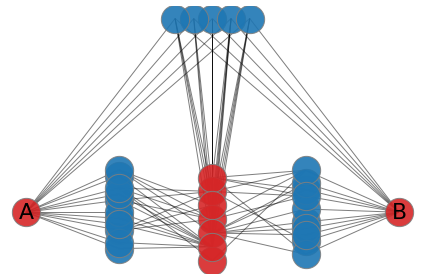

In [208]:
for i, (p, a) in enumerate(paper2author.items()):
  if len(a) > 5:
    a1, a2 = np.random.choice(a, 2, replace=False)
  else:
    continue
  nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
  sg = g.subgraph(nodes)
  draw(sg, a1, a2, p1, p2, b3)
  if i > 20:
    break

In [47]:
sg.degree

DegreeView({'p_196352': 2, 'a_746277': 5, 'a_1869708': 1, 'p_27': 6, 'p_117733': 4, 'p_159224': 5, 'p_314087': 2, 'p_389720': 4, 'a_711107': 5, 'p_26239': 2, 'p_280921': 2, 'a_2143723': 11, 'p_398376': 2, 'a_1179874': 8, 'p_52255': 2, 'p_73060': 2, 'p_122224': 3, 'a_2117503': 5, 'p_349040': 7, 'p_17207': 2, 'a_554740': 16, 'p_25425': 6, 'p_312003': 4, 'p_280528': 6, 'a_318402': 14, 'p_294608': 4})

In [48]:
pp1, pp2, bb3, pp = [], [], [], []
for i, (a1, a2) in enumerate(tqdm(train_set)):
  nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
  pp1.append(len(p1))
  pp2.append(len(p2))
  pp.append(len(p1) + len(p2))
  bb3.append(len(b3))
  # if len(p1) + len(p2) < 30:
  #   sg = g.subgraph(nodes)
  #   print(a1, a2, len(p1) + len(p2))
  #   draw(sg, a1, a2, p1, p2, b3)
  # if i > 10:
    # break
  # print(len(nodes))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 93.59it/s]


MIN MAX MEDIAN MEAN STD LEN
1 452 13.0 32.018 56.763154211160604 2000


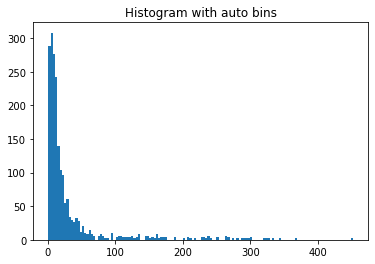

In [49]:
histogram(bb3)

  0%|                                                                                                                                                                   | 0/2000 [00:00<?, ?it/s]

['p_152743', 'p_335211', 'p_353590', 'p_412232', 'p_415353', 'p_239150', 'p_126676', 'p_366948', 'p_38442', 'p_34049', 'p_374804', 'p_304857', 'p_285220', 'p_154089', 'p_282673', 'p_32023', 'p_103336', 'p_321818', 'p_30437', 'p_284475', 'p_145033', 'p_275583', 'p_100520', 'p_14757', 'p_209609', 'p_198231']


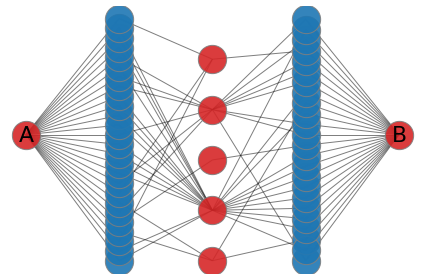

  0%|                                                                                                                                                           | 1/2000 [00:00<04:42,  7.09it/s]

['p_361142', 'p_338721', 'p_155752', 'p_116768', 'p_183874', 'p_331890', 'p_241210', 'p_198727', 'p_280223', 'p_143789', 'p_180021', 'p_50880', 'p_198642', 'p_307840', 'p_212748', 'p_31018', 'p_26909', 'p_3781', 'p_60363', 'p_230182', 'p_177701', 'p_249780', 'p_99683', 'p_146064']


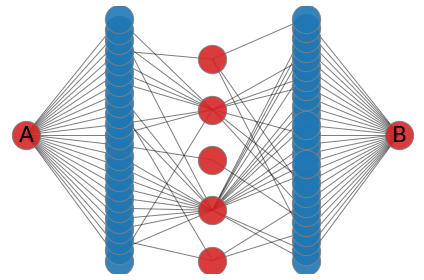

  0%|▏                                                                                                                                                          | 2/2000 [00:00<04:44,  7.02it/s]

['p_139618', 'p_120126', 'p_29068', 'p_25026', 'p_384821', 'p_400691', 'p_416024', 'p_130028', 'p_80356', 'p_198821', 'p_92570', 'p_227374', 'p_174001', 'p_320803', 'p_278224', 'p_338346', 'p_69400', 'p_236742', 'p_262643', 'p_259575', 'p_370231', 'p_35335', 'p_249235', 'p_123449', 'p_372757', 'p_17915', 'p_74600', 'p_134987', 'p_313792', 'p_262605', 'p_133975', 'p_173272', 'p_325661', 'p_438501', 'p_169937', 'p_429260', 'p_355339', 'p_326310', 'p_417905', 'p_380543', 'p_429517', 'p_275900', 'p_160661', 'p_195954', 'p_32010', 'p_36073', 'p_161032', 'p_224962', 'p_337689', 'p_411361', 'p_212234', 'p_92105', 'p_410317', 'p_193288', 'p_151793', 'p_181757', 'p_101502', 'p_312523', 'p_442055', 'p_398330', 'p_369297', 'p_66305', 'p_56044', 'p_212355', 'p_228896', 'p_278034', 'p_66159', 'p_200572', 'p_273268', 'p_301626', 'p_337869', 'p_204444', 'p_200119', 'p_341114', 'p_306119', 'p_182202', 'p_391003', 'p_94363', 'p_223459', 'p_64062', 'p_137366', 'p_154410', 'p_378857', 'p_43200', 'p_25925

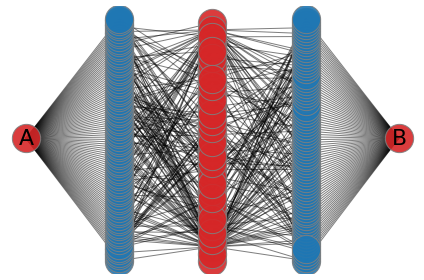

  0%|▏                                                                                                                                                          | 3/2000 [00:00<06:28,  5.14it/s]

['p_206532', 'p_227757', 'p_429234', 'p_424774', 'p_447188', 'p_209983', 'p_446231', 'p_152005', 'p_74533', 'p_34056', 'p_45788', 'p_83751', 'p_292805', 'p_137507', 'p_97208', 'p_139648', 'p_97890', 'p_308895', 'p_114469', 'p_172502', 'p_415341', 'p_342124', 'p_55236', 'p_311213', 'p_63235', 'p_63592', 'p_222466', 'p_416656', 'p_32481', 'p_354557', 'p_329398', 'p_11329', 'p_250639', 'p_236202', 'p_181581', 'p_26739', 'p_346797', 'p_126247', 'p_379963', 'p_63401', 'p_292911', 'p_327723', 'p_5781', 'p_200883', 'p_148226', 'p_51715', 'p_328678', 'p_239885', 'p_376831', 'p_33027', 'p_338136', 'p_85232', 'p_342944', 'p_128421', 'p_286442', 'p_274984', 'p_408044', 'p_242828', 'p_34264', 'p_235230', 'p_328024', 'p_251331', 'p_296465', 'p_439785', 'p_213934', 'p_375884', 'p_225954', 'p_275116', 'p_378056', 'p_386240', 'p_345893', 'p_97161', 'p_278364', 'p_391478', 'p_87903', 'p_374302', 'p_289245', 'p_92999', 'p_345836', 'p_65165', 'p_431017', 'p_354043', 'p_153318']


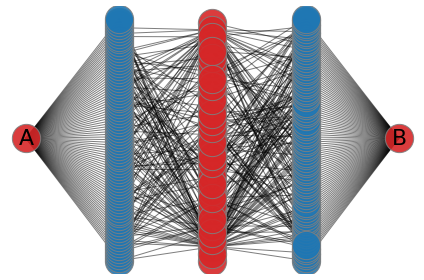

  0%|▎                                                                                                                                                          | 4/2000 [00:00<07:15,  4.58it/s]

['p_210217', 'p_29223', 'p_147539', 'p_227478', 'p_71698', 'p_326636', 'p_14395', 'p_206310', 'p_31643', 'p_311735', 'p_129240', 'p_10120', 'p_277448', 'p_315447', 'p_25894', 'p_13049', 'p_276375', 'p_392488', 'p_361492', 'p_157625', 'p_372005', 'p_219022']


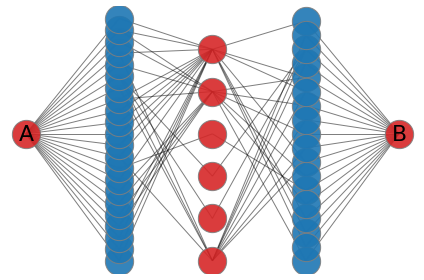

  0%|▍                                                                                                                                                          | 5/2000 [00:00<06:25,  5.17it/s]

['p_369371', 'p_255628', 'p_359208', 'p_360423', 'p_25917', 'p_121461', 'p_153990', 'p_278300', 'p_362365', 'p_184084', 'p_303208', 'p_245626', 'p_406708', 'p_48095', 'p_83650', 'p_239836', 'p_183113', 'p_299207']


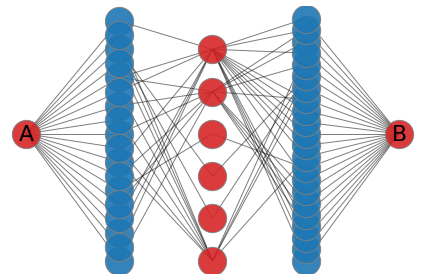

  0%|▍                                                                                                                                                          | 6/2000 [00:01<05:48,  5.72it/s]

['p_285774', 'p_191236', 'p_188161', 'p_417018', 'p_219921', 'p_307331', 'p_422438', 'p_17431', 'p_32545', 'p_195262', 'p_386326', 'p_141466', 'p_112215', 'p_327644', 'p_237842', 'p_171379', 'p_424713', 'p_363561', 'p_249786', 'p_374547', 'p_260886', 'p_298467', 'p_71527', 'p_201812', 'p_436877', 'p_351140', 'p_306740', 'p_111622', 'p_407808', 'p_126884', 'p_342039', 'p_254991']


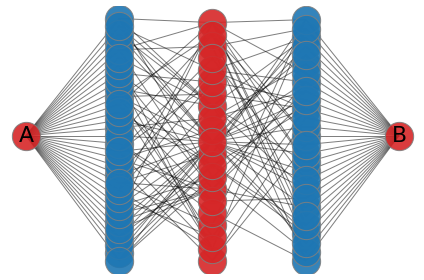

  0%|▌                                                                                                                                                          | 7/2000 [00:01<05:42,  5.81it/s]

['p_84835', 'p_428241', 'p_36', 'p_352979', 'p_45656', 'p_102969', 'p_173525', 'p_51860', 'p_255746', 'p_344167', 'p_187373', 'p_226154', 'p_116242', 'p_277416', 'p_183970', 'p_216872', 'p_337199', 'p_349331', 'p_331812', 'p_73301', 'p_307328', 'p_225122', 'p_330390', 'p_216152', 'p_236805', 'p_236005', 'p_446344', 'p_439765']


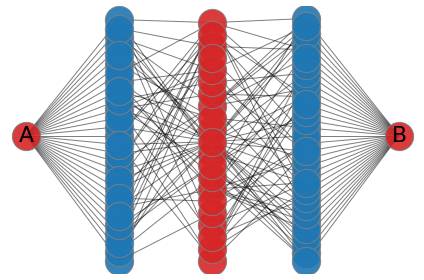

  0%|▌                                                                                                                                                          | 8/2000 [00:01<05:38,  5.88it/s]

['p_103679', 'p_208628', 'p_222761', 'p_331790', 'p_294813', 'p_31767', 'p_297831', 'p_307768', 'p_397421', 'p_400144', 'p_259835', 'p_233585', 'p_363151', 'p_421251', 'p_16751', 'p_249157', 'p_371540', 'p_431913', 'p_206209', 'p_120672', 'p_402220', 'p_261909', 'p_384077', 'p_73161', 'p_241518', 'p_157940', 'p_443069', 'p_445137', 'p_187928', 'p_22060', 'p_109416', 'p_118086', 'p_386315', 'p_67054', 'p_87705', 'p_98676', 'p_425778', 'p_390114', 'p_298552', 'p_383005', 'p_211835', 'p_210412', 'p_393303', 'p_90287', 'p_264884', 'p_117485', 'p_69994', 'p_55660', 'p_128157', 'p_346704', 'p_370606', 'p_37293', 'p_31582', 'p_47520', 'p_440662', 'p_302068', 'p_88684', 'p_375870', 'p_427100', 'p_381893', 'p_358888', 'p_236767', 'p_94450', 'p_159342', 'p_278389', 'p_122866', 'p_144930', 'p_29047', 'p_423509', 'p_359876', 'p_168092', 'p_17850', 'p_113304', 'p_280261', 'p_280570', 'p_65908', 'p_180571', 'p_8568', 'p_101759', 'p_405598', 'p_372554', 'p_197171', 'p_148854', 'p_433106', 'p_374776',

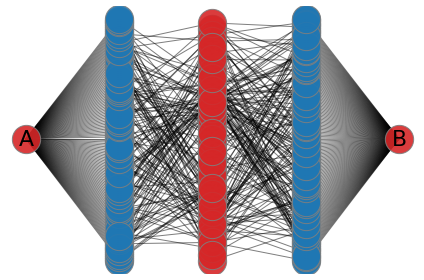

  0%|▋                                                                                                                                                          | 9/2000 [00:01<07:09,  4.64it/s]

['p_228319', 'p_135577', 'p_284120', 'p_98582', 'p_259113', 'p_160006', 'p_195890', 'p_418585', 'p_227803', 'p_216294', 'p_17563', 'p_30820', 'p_232609', 'p_303690', 'p_267796', 'p_32863', 'p_316306', 'p_186755', 'p_374780', 'p_406078', 'p_342132', 'p_425982', 'p_73259', 'p_253935', 'p_207098', 'p_59606', 'p_124575', 'p_275216', 'p_229203', 'p_133953', 'p_283384', 'p_5238', 'p_103624', 'p_421639', 'p_175824', 'p_362798', 'p_104212', 'p_267496', 'p_89532', 'p_108986', 'p_92584', 'p_210897', 'p_317208', 'p_221464', 'p_20497', 'p_408955', 'p_155719', 'p_363913', 'p_442640', 'p_6274', 'p_79956', 'p_321166', 'p_288006', 'p_179550', 'p_293452', 'p_276121', 'p_206333', 'p_362309', 'p_433847', 'p_358256', 'p_358391', 'p_369331', 'p_188368', 'p_148715', 'p_149373', 'p_32450', 'p_295083', 'p_423709', 'p_52916', 'p_213588', 'p_192674', 'p_333675', 'p_139337', 'p_425691', 'p_270349', 'p_438499', 'p_82553', 'p_417703', 'p_169496', 'p_173782', 'p_311479', 'p_381220', 'p_161238', 'p_69611', 'p_203830

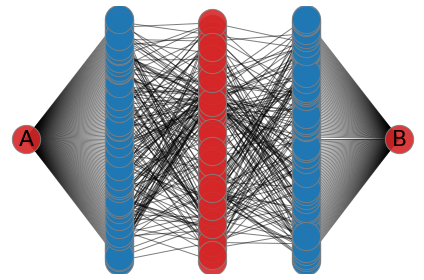

  0%|▊                                                                                                                                                         | 10/2000 [00:03<22:17,  1.49it/s]

['p_15008', 'p_3135', 'p_187806', 'p_439071', 'p_178008', 'p_189156', 'p_307957', 'p_12552', 'p_257335', 'p_312645', 'p_362114', 'p_42543', 'p_265964', 'p_102008', 'p_355832', 'p_39413', 'p_100143', 'p_203198', 'p_192673', 'p_225218', 'p_72687', 'p_224918', 'p_359039', 'p_23094', 'p_354731', 'p_46194', 'p_310268', 'p_99566', 'p_413946', 'p_107731', 'p_339005', 'p_10283', 'p_18455', 'p_107771', 'p_186927', 'p_194175', 'p_383182', 'p_110844', 'p_158724', 'p_366922', 'p_334408', 'p_197580', 'p_369677', 'p_174266', 'p_168700', 'p_282618', 'p_355776', 'p_58972', 'p_99666', 'p_5868', 'p_344131', 'p_152494', 'p_2247', 'p_90090', 'p_157409', 'p_13894', 'p_67578', 'p_72975', 'p_417929', 'p_191897', 'p_113994', 'p_245759', 'p_245965', 'p_159511', 'p_106462', 'p_30196', 'p_322061', 'p_251154', 'p_443916', 'p_376896']


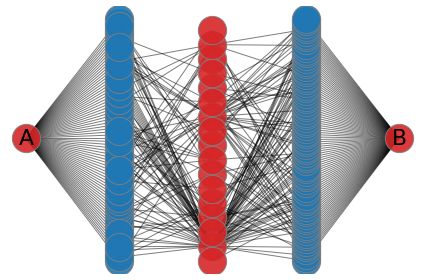

  1%|▊                                                                                                                                                         | 11/2000 [00:03<17:46,  1.87it/s]

['p_383314', 'p_115100', 'p_427039', 'p_247988', 'p_240936', 'p_78870', 'p_311717', 'p_293351', 'p_403816', 'p_113551', 'p_61158', 'p_333683', 'p_54331', 'p_47027', 'p_309807', 'p_253868', 'p_367753', 'p_258327', 'p_215837', 'p_445595', 'p_107544', 'p_115760', 'p_264817', 'p_102371', 'p_447664', 'p_415779', 'p_21397', 'p_391245', 'p_249241', 'p_202043', 'p_164052', 'p_421557', 'p_247872', 'p_119801', 'p_439647', 'p_159982', 'p_62673', 'p_261219', 'p_277218', 'p_398416', 'p_427385', 'p_228663', 'p_393030', 'p_46840', 'p_402321', 'p_228890', 'p_223363', 'p_441632', 'p_152876', 'p_340496', 'p_231298', 'p_208255', 'p_194258', 'p_414696', 'p_243181', 'p_412885', 'p_130337', 'p_365052', 'p_412541', 'p_113132', 'p_8154', 'p_118873', 'p_48312', 'p_24272', 'p_2592', 'p_23171', 'p_196132', 'p_414554', 'p_187386', 'p_410649', 'p_37925', 'p_215466', 'p_180947', 'p_84259', 'p_169919', 'p_234737', 'p_358348', 'p_275181', 'p_356416', 'p_109667', 'p_299042', 'p_155767', 'p_218074', 'p_306828', 'p_8240

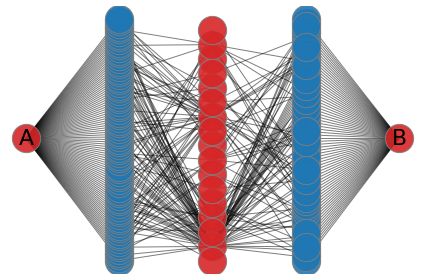

  1%|▊                                                                                                                                                         | 11/2000 [00:03<11:41,  2.84it/s]


In [50]:
for i, (a1, a2) in enumerate(tqdm(train_set)):
  nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
  print(p1)
  sg = g.subgraph(nodes)
  draw(sg, a1, a2, p1, p2, b3)
  if i > 10:
    break
  # print(len(nodes))

In [51]:
pp1, pp2, bb3, pp = [], [], [], []
for i, ((a1, a2), v) in enumerate(tqdm(valid_set.items())):
  if not v:
    nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
    pp1.append(len(p1))
    pp2.append(len(p2))
    bb3.append(len(b3))
    pp.append(len(p1) + len(p2))
#     if len(p1) + len(p2) > 20:
    sg = g.subgraph(nodes)
    draw(sg, a1, a2, p1, p2, b3)
  # if i > 510:
  #   break
  # print(a1, a2, list(asp))
  break

  0%|                                                                                                                                                                   | 0/1000 [00:00<?, ?it/s]


In [52]:
histogram(pp)

  0%|                                                                                                                                                                   | 0/1000 [00:00<?, ?it/s]

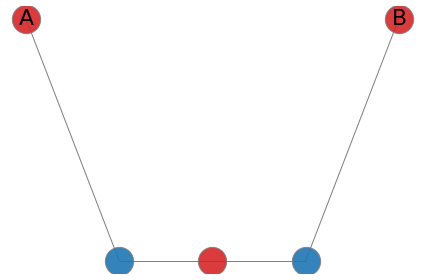

  0%|                                                                                                                                                                   | 0/1000 [00:00<?, ?it/s]


In [53]:
pp1, pp2, bb3, pp = [], [], [], []
for i, ((a1, a2), v) in enumerate(tqdm(qq_set.items())):
  if not v:
    nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
    pp1.append(len(p1))
    pp2.append(len(p2))
    bb3.append(len(b3))
    pp.append(len(p1) + len(p2))
    if len(p1) + len(p2) < 20:
      sg = g.subgraph(nodes)
      draw(sg, a1, a2, p1, p2, b3)
  # if i > 510:
  #   break
  # print(a1, a2, list(asp))
  break

MIN MAX MEDIAN MEAN STD LEN
2 2 2.0 2.0 0.0 1


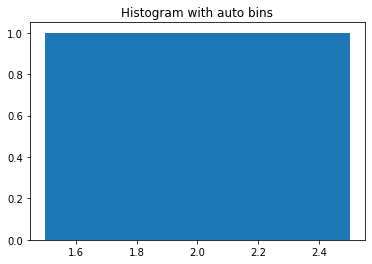

In [54]:
histogram(pp)

### Load Node2Vec

In [55]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html
You should consider upgrading via the '/home/mahi/anaconda3/envs/risk/bin/python -m pip install --upgrade pip' command.


In [56]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
You should consider upgrading via the '/home/mahi/anaconda3/envs/risk/bin/python -m pip install --upgrade pip' command.


In [57]:
import random
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn.parallel import data_parallel
import torch.nn.functional as F

from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, Node2Vec, SAGEConv, GraphConv, GINConv, GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx
from torch_scatter import scatter_mean, scatter_max, scatter_sum

In [238]:
data_list = []
single = False
add_node = True
local_feat = True

In [239]:
# LOAD Positive Samples
for a1, a2 in tqdm(train_set):
    nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
    sg = g.subgraph(nodes).copy()
    if local_feat:
        for node in sg.nodes():
            nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
            sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
    if add_node:
        sg.add_node('reduce_0', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
        sg.add_node('reduce_1', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
        if single:
            sg.add_edge(a1, 'reduce_0')
            sg.add_edge(a2, 'reduce_0')
            sg.add_edge(a1, 'reduce_1')
            sg.add_edge(a2, 'reduce_1')
        else:
            sg.add_edges_from([[n, 'reduce_0'] for n in sg.nodes()])
            sg.add_edges_from([[n, 'reduce_1'] for n in sg.nodes()])
    
    data = from_networkx(sg, ['feat'])
    data.y = 1.0
    data = T.ToUndirected()(data)
    data = T.AddSelfLoops()(data)
    data.edge_attr = torch.tensor([((data.x[a]+data.x[b])/2).numpy() for a,b in data.edge_index.t()])
    data_list.append(data)
data_list = data_list * 3

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:25<00:00,  7.53it/s]


In [60]:
# # LOAD Negetive Samples (Same Paper)
# papers = np.random.choice(list(paper2author), 2000, replace=False)
# for paper in tqdm(papers):
#     a1, a2 = np.random.choice(paper2author[paper], 2, replace=False)
#     nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
#     sg = g.subgraph(nodes).copy()
#     if local_feat:
#         for node in sg.nodes():
#             nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
#             sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
#     if add_node:
#         sg.add_node('reduce', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
#         if single:
#             sg.add_edge(a1, 'reduce')
#             sg.add_edge(a2, 'reduce')
#         else:
#             sg.add_edges_from([[n, 'reduce'] for n in sg.nodes()])
#     data = from_networkx(sg, ['feat'])
#     data.y = 0.0
#     data = T.ToUndirected()(data)
#     data = T.AddSelfLoops()(data)
#     data_list.append(data)

In [240]:
# LOAD Almost Negetive Samples from (low connection)
authros2candidate, prob = get_candidate(1, 25, 1, 25, 200)
for i in tqdm(range(10)):
    for aut, cand in authros2candidate.items():
        a1, a2 = aut, np.random.choice(cand)
        nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
        sg = g.subgraph(nodes).copy()
        if local_feat:
            for node in sg.nodes():
                nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
                sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
        if add_node:
            sg.add_node('reduce_0', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
            sg.add_node('reduce_1', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
            if single:
                sg.add_edge(a1, 'reduce_0')
                sg.add_edge(a2, 'reduce_0')
                sg.add_edge(a1, 'reduce_1')
                sg.add_edge(a2, 'reduce_1')
            else:
                sg.add_edges_from([[n, 'reduce_0'] for n in sg.nodes()])
                sg.add_edges_from([[n, 'reduce_1'] for n in sg.nodes()])
        
        data = from_networkx(sg, ['feat'])
        data.y = 0.0
        data = T.ToUndirected()(data)
        data = T.AddSelfLoops()(data)
        data.edge_attr = torch.tensor([((data.x[a]+data.x[b])/2).numpy() for a,b in data.edge_index.t()])
        data_list.append(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


In [137]:
authros2candidate = get_neg_candidate(train_set)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 66.49it/s]


MIN MAX MEDIAN MEAN STD LEN
1 14313 719.0 1479.2706353176588 1965.6832633053998 1999


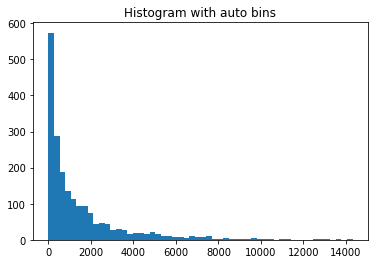

In [139]:
histogram([len(v) for v in authros2candidate.values()])

In [ ]:
# LOAD Negetive Samples
authros2candidate = get_neg_candidate(train_set)
for aut, cand in tqdm(authros2candidate.items()):
    a1, a2 = aut, np.random.choice(cand)
    nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
    sg = g.subgraph(nodes).copy()
    if local_feat:
        for node in sg.nodes():
            nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
            sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
    if add_node:
        sg.add_node('reduce_0', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
        sg.add_node('reduce_1', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
        if single:
            sg.add_edge(a1, 'reduce_0')
            sg.add_edge(a2, 'reduce_0')
            sg.add_edge(a1, 'reduce_1')
            sg.add_edge(a2, 'reduce_1')
        else:
            sg.add_edges_from([[n, 'reduce_0'] for n in sg.nodes()])
            sg.add_edges_from([[n, 'reduce_1'] for n in sg.nodes()])

    data = from_networkx(sg, ['feat'])
    data.y = 0.0
    data = T.ToUndirected()(data)
    data = T.AddSelfLoops()(data)
    data.edge_attr = torch.tensor([((data.x[a]+data.x[b])/2).numpy() for a,b in data.edge_index.t()])
    data_list.append(data)

In [241]:
# LOAD Almost Negetive Samples from (high connection)
authros2candidate, prob = get_candidate(30, 100_000, 30, 100_000, 500)
for i in tqdm(range(1 + 4000 // len(authros2candidate))):
    for aut, cand in authros2candidate.items():
        a1, a2 = aut, np.random.choice(cand)
        nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
        sg = g.subgraph(nodes).copy()
        if local_feat:
            for node in sg.nodes():
                nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
                sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
        if add_node:
            sg.add_node('reduce_0', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
            sg.add_node('reduce_1', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
            if single:
                sg.add_edge(a1, 'reduce_0')
                sg.add_edge(a2, 'reduce_0')
                sg.add_edge(a1, 'reduce_1')
                sg.add_edge(a2, 'reduce_1')
            else:
                sg.add_edges_from([[n, 'reduce_0'] for n in sg.nodes()])
                sg.add_edges_from([[n, 'reduce_1'] for n in sg.nodes()])

        data = from_networkx(sg, ['feat'])
        data.y = 0.0
        data = T.ToUndirected()(data)
        data = T.AddSelfLoops()(data)
        data.edge_attr = torch.tensor([((data.x[a]+data.x[b])/2).numpy() for a,b in data.edge_index.t()])
        data_list.append(data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [20:49<00:00, 156.19s/it]


In [242]:
sum([data.y for data in data_list]), len(data_list)

(6000.0, 12018)

In [243]:
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter

from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)
from torch.nn import Parameter
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

from torch_geometric.nn.inits import glorot, zeros


class EGATConv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        edge_dim (int, optional): Edge feature dimensionality (in case
            there are any). (default: :obj:`None`)
        fill_value (float or Tensor or str, optional): The way to generate
            edge features of self-loops (in case :obj:`edge_dim != None`).
            If given as :obj:`float` or :class:`torch.Tensor`, edge features of
            self-loops will be directly given by :obj:`fill_value`.
            If given as :obj:`str`, edge features of self-loops are computed by
            aggregating all features of edges that point to the specific node,
            according to a reduce operation. (:obj:`"add"`, :obj:`"mean"`,
            :obj:`"min"`, :obj:`"max"`, :obj:`"mul"`). (default: :obj:`"mean"`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        negative_slope: float = 0.2,
        dropout: float = 0.0,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        if isinstance(in_channels, int):
            self.lin_src = Linear(in_channels, heads * out_channels,
                                  bias=False, weight_initializer='glorot')
            self.lin_dst = self.lin_src
        else:
            self.lin_src = Linear(in_channels[0], heads * out_channels, False,
                                  weight_initializer='glorot')
            self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
                                  weight_initializer='glorot')

        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))

        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
            self.att_edge = Parameter(torch.Tensor(1, heads, out_channels))
        else:
            self.lin_edge = None
            self.register_parameter('att_edge', None)

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_src.reset_parameters()
        self.lin_dst.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att_src)
        glorot(self.att_dst)
        glorot(self.att_edge)
        zeros(self.bias)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None,
                return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        # NOTE: attention weights will be returned whenever
        # `return_attention_weights` is set to a value, regardless of its
        # actual value (might be `True` or `False`). This is a current somewhat
        # hacky workaround to allow for TorchScript support via the
        # `torch.jit._overload` decorator, as we can only change the output
        # arguments conditioned on type (`None` or `bool`), not based on its
        # actual value.

        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = x_dst = self.lin_src(x).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        # Next, we compute node-level attention coefficients, both for source
        # and target nodes (if present):
        alpha_src = (x_src * self.att_src).sum(dim=-1)
        alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
        alpha = (alpha_src, alpha_dst)

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor, edge_attr: OptTensor)  # noqa
        out = self.propagate(edge_index, x=x, alpha=alpha, edge_attr=edge_attr,
                             size=size)

        alpha = self._alpha
        assert alpha is not None
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out += self.bias
        if edge_attr is not None:
            edgemat = self.__edgemat__
            self.__edgemat__ = None
            if isinstance(return_attention_weights, bool):
                if isinstance(edge_index, Tensor):
                    return out, (edge_index, alpha), edgemat
                elif isinstance(edge_index, SparseTensor):
                    return out, edge_index.set_value(alpha, layout='coo'), edgemat
            else:
                return out, edgemat
        
        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        # Given edge-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        if edge_attr is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            assert self.lin_edge is not None
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            alpha_edge = (edge_attr * self.att_edge).sum(dim=-1)
            alpha = alpha + alpha_edge
            self.__edgemat__ = edge_attr
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha  # Save for later use.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [244]:
class GNN(torch.nn.Module):
    def __init__(self, node_feat, hidden, conv):
        super().__init__()
        self.conv1 = conv(node_feat, hidden, edge_dim=5, add_self_loops=False, fill_value='mean')
        self.conv2 = conv(hidden, hidden, edge_dim=hidden, add_self_loops=False, fill_value='mean')
        self.conv3 = conv(hidden, hidden, edge_dim=hidden, add_self_loops=False, fill_value='mean')

        self.classifier0 = nn.Linear(hidden, 1)
        self.classifier1 = nn.Linear(hidden, 1)

    def get_info(self, data):
        x, edge_index = data.x, data.edge_index
        if add_node:
          node_index = [a-1 for a in data.ptr.cpu().numpy()[1:]]

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x2 = self.conv2(x, edge_index)
        x2 = F.relu(x2)
        x2 = F.dropout(x2, training=self.training)
        return x, x2
        
    def forward(self, data, ret_att=False):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        if add_node:
          node_index_0 = [a-2 for a in data.ptr.cpu().numpy()[1:]]
          node_index_1 = [a-1 for a in data.ptr.cpu().numpy()[1:]]
#         if ret_att:
        x, a1, e = self.conv1(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.relu(x)
        e = e.squeeze()
        x = F.dropout(x, training=self.training)
        x, a2, e = self.conv2(x, edge_index, e, return_attention_weights=True)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        e = e.squeeze()
        x, a3, e = self.conv3(x, edge_index, e, return_attention_weights=True)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
#         else:   
#             x = self.conv1(x, edge_index)
#             x = F.relu(x)
#             x = F.dropout(x, training=self.training)
#             x = self.conv2(x, edge_index)
#             x = F.relu(x)
#             x = F.dropout(x, training=self.training)
#             x = self.conv3(x, edge_index)
#             x = F.relu(x)
#             x = F.dropout(x, training=self.training)
        # print(x.shape)
        if add_node:
          x0 = x[node_index_0]
          x1 = x[node_index_1]
        else:
          x = scatter_mean(x, data.batch, dim=0)
        # print(x.shape)
        x0 = self.classifier0(x0)
        x1 = self.classifier1(x1)
        if ret_att:
            return torch.sigmoid(x0), torch.sigmoid(x1), a1, a2, a3
        else:
            return torch.sigmoid(x0), torch.sigmoid(x1)

In [245]:
class GCN(torch.nn.Module):
    def __init__(self, node_feat, hidden):
        super().__init__()
        self.conv1 = GCNConv(node_feat, hidden)
        self.conv2 = GCNConv(hidden, hidden)

        self.classifier = nn.Linear(hidden, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        node_index = [a-1 for a in data.ptr.cpu().numpy()[1:]]

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # print(x.shape)
        x = self.classifier(x[node_index])
        return torch.sigmoid(x)

In [246]:
import logging
import torch
import time
import numpy as np
import random
import json
import os

LOGGER = logging.getLogger(__name__)

def init_logging():
    logging.basicConfig(format='[%(asctime)s] [%(levelname)s] [%(name)s]  %(message)s', level=logging.DEBUG)

def get_ms():
    """Returns the current time in milliseconds."""
    return time.time() * 1000


def init_seed(seed=None):
    global SEED
    """Seed the RNGs for predictability/reproduction purposes."""
    if seed is None:
        seed = int(get_ms() // 1000)
    SEED = seed
    LOGGER.info("Using seed=%d", seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)


def progress_clean():
    """Clean the progress bar."""
    print("\r{}".format(" " * 80), end='\r')


def progress_bar(batch_num, report_interval, last_loss):
    """Prints the progress until the next report."""
    progress = (((batch_num - 1) % report_interval) + 1) / report_interval
    fill = int(progress * 40)
    print("\r[{}{}]: {} (Loss: {:.4f})".format("=" * (fill - 1) + ">", " " * (40 - fill), batch_num, last_loss), end='')


def save_checkpoint(net, batch_num, ratio, losses, costs, checkpoint_path='/gdrive/MyDrive/AI706/dataset/model'):
    progress_clean()
    if not os.path.exists(checkpoint_path):
        os.mkdir(checkpoint_path)
    basename = "{}/{}-batch-{}".format(checkpoint_path, ratio, batch_num)
    model_fname = basename + ".model"
    print("Saving model checkpoint to: '{}'".format(model_fname))
    torch.save(net.state_dict(), model_fname)

    # Save the training history
    train_fname = basename + ".json"
    print("Saving model training history to '{}'".format(train_fname))
    content = {
        "loss": losses,
        "cost": costs
    }
    open(train_fname, 'wt').write(json.dumps(content))


def clip_grads(net):
    """Gradient clipping to the range [10, 10]."""
    parameters = list(filter(lambda p: p.grad is not None, net.parameters()))
    for p in parameters:
        p.grad.data.clamp_(-10, 10)

In [247]:
def train_batch(net, criterion, optimizer, X, Y, batch_size, is_cuda=False):
  """Trains a single batch."""
  optimizer.zero_grad()
  if is_cuda:
    P0, P1 = data_parallel(net, X, device_ids=[0])
  else:
    P0, P1 = net(X)

  if is_cuda:
    X = X.cuda()
    Y = Y.cuda()
    P0 = P0.cuda()
    P1 = P1.cuda()
  P0 = P0.squeeze()
  P1 = P1.squeeze()
  loss = criterion(P0, 1 - Y.double()) + criterion(P1, Y.double())
  loss.backward()
  clip_grads(net)
  optimizer.step()

  if is_cuda:
      y_out_binarized = P1.cpu().data
  else:
      y_out_binarized = P1.clone().data
  y_out_binarized.apply_(lambda x: 0 if x < 0.5 else 1)

  # The cost is the number of error bits per sequence
  cost = torch.sum(torch.abs(y_out_binarized - Y.cpu().data))
  # print(cost)
  return loss.item(), cost.item() / batch_size

In [248]:
# net = GCN(5, 128).double()
net = GNN(5, 64, EGATConv).double()
losses = []
costs = []
repeats = []
start_ms = get_ms()


In [249]:
is_cuda = True

SEED = 1
batch_size = 256
batch_num = 200

init_seed(SEED)
init_logging()
report_interval = len(data_list) // batch_size
checkpoint_interval =  len(data_list) // batch_size

criterion = nn.MSELoss()
optimizer =  optim.RMSprop(net.parameters(), momentum=0.9, alpha=0.95, lr=1e-5)

if is_cuda:
  net = net.cuda()


# random.shuffle(data_list)
loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

[2021-12-09 20:02:25,142] [INFO] [__main__]  Using seed=1


In [250]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)

17922

In [251]:
net.train()
for r in range(batch_num):
  # print(r)
  for i, batch in enumerate(loader):
    x = batch
    y = batch.y

    if is_cuda:
      x = x.cuda()
      y = y.cuda()

    loss, cost = train_batch(net, criterion, optimizer, x, y, batch_size, is_cuda)
    losses += [loss]
    costs += [cost]
    # Update the progress bar
    progress_bar(i, report_interval, loss)
    # print(' (Cost: {})'.format(cost))
    # print(i)
    # Report
    if i % report_interval == 0 and i:
        mean_loss = np.array(losses[-report_interval:]).mean()
        mean_cost = np.array(costs[-report_interval:]).mean()
        mean_time = int(((get_ms() - start_ms)) / batch_size)
        progress_clean()
        LOGGER.info(
            "Epoch {} :: Batch {} Loss: {} Cost: {} Time: {} ms/sequence".format(r, i, mean_loss, mean_cost, mean_time))
        start_ms = get_ms()

    # Checkpoint
    # if (checkpoint_interval != 0) and (i % checkpoint_interval == 0):
    #   save_checkpoint(net, i, r, losses, costs)


[======================================> ]: 45 (Loss: 0.6017)

[2021-12-09 20:02:38,828] [INFO] [__main__]  Epoch 0 :: Batch 46 Loss: 0.6577209416384305 Cost: 0.5090013586956522 Time: 53 ms/sequence


[======================================> ]: 45 (Loss: 0.5145)                   

[2021-12-09 20:02:52,099] [INFO] [__main__]  Epoch 1 :: Batch 46 Loss: 0.5530510125262542 Cost: 0.4974524456521739 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.4938)                   

[2021-12-09 20:03:04,552] [INFO] [__main__]  Epoch 2 :: Batch 46 Loss: 0.5069715057177189 Cost: 0.4757133152173913 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.4755)                   

[2021-12-09 20:03:16,906] [INFO] [__main__]  Epoch 3 :: Batch 46 Loss: 0.4928134458281056 Cost: 0.4486243206521739 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.4484)                   

[2021-12-09 20:03:29,846] [INFO] [__main__]  Epoch 4 :: Batch 46 Loss: 0.4684201261216617 Cost: 0.41694972826086957 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.4401)                   

[2021-12-09 20:03:42,216] [INFO] [__main__]  Epoch 5 :: Batch 46 Loss: 0.44061790907925635 Cost: 0.3669327445652174 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.4048)                   

[2021-12-09 20:03:54,613] [INFO] [__main__]  Epoch 6 :: Batch 46 Loss: 0.41978090056640643 Cost: 0.33381453804347827 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3890)                   

[2021-12-09 20:04:07,030] [INFO] [__main__]  Epoch 7 :: Batch 46 Loss: 0.4032056435993385 Cost: 0.31997282608695654 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3908)                   

[2021-12-09 20:04:19,459] [INFO] [__main__]  Epoch 8 :: Batch 46 Loss: 0.38738037801136466 Cost: 0.3018851902173913 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3836)                   

[2021-12-09 20:04:31,770] [INFO] [__main__]  Epoch 9 :: Batch 46 Loss: 0.3756364741557325 Cost: 0.2977241847826087 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3488)                   

[2021-12-09 20:04:44,087] [INFO] [__main__]  Epoch 10 :: Batch 46 Loss: 0.36342112846292063 Cost: 0.2944972826086957 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3166)                   

[2021-12-09 20:04:56,647] [INFO] [__main__]  Epoch 11 :: Batch 46 Loss: 0.3502303698172927 Cost: 0.2815047554347826 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.3406)                   

[2021-12-09 20:05:08,805] [INFO] [__main__]  Epoch 12 :: Batch 46 Loss: 0.34020475593922034 Cost: 0.27292798913043476 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2951)                   

[2021-12-09 20:05:21,282] [INFO] [__main__]  Epoch 13 :: Batch 46 Loss: 0.3246278977071863 Cost: 0.2603600543478261 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3086)                   

[2021-12-09 20:05:33,686] [INFO] [__main__]  Epoch 14 :: Batch 46 Loss: 0.31641197675713956 Cost: 0.2505944293478261 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3125)                   

[2021-12-09 20:05:46,096] [INFO] [__main__]  Epoch 15 :: Batch 46 Loss: 0.30806787781522266 Cost: 0.22707201086956522 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2738)                   

[2021-12-09 20:05:58,503] [INFO] [__main__]  Epoch 16 :: Batch 46 Loss: 0.30073511217568727 Cost: 0.20847486413043478 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.3160)                   

[2021-12-09 20:06:10,907] [INFO] [__main__]  Epoch 17 :: Batch 46 Loss: 0.2909919516093509 Cost: 0.19276494565217392 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2690)                   

[2021-12-09 20:06:23,165] [INFO] [__main__]  Epoch 18 :: Batch 46 Loss: 0.28597435811413874 Cost: 0.18291440217391305 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2644)                   

[2021-12-09 20:06:35,312] [INFO] [__main__]  Epoch 19 :: Batch 46 Loss: 0.2790468096383604 Cost: 0.17128057065217392 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2889)                   

[2021-12-09 20:06:47,598] [INFO] [__main__]  Epoch 20 :: Batch 46 Loss: 0.26996692108272335 Cost: 0.16576086956521738 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2639)                   

[2021-12-09 20:06:59,966] [INFO] [__main__]  Epoch 21 :: Batch 46 Loss: 0.2654991666038527 Cost: 0.16185461956521738 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2717)                   

[2021-12-09 20:07:12,682] [INFO] [__main__]  Epoch 22 :: Batch 46 Loss: 0.2622654336829063 Cost: 0.15998641304347827 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.3098)                   

[2021-12-09 20:07:25,050] [INFO] [__main__]  Epoch 23 :: Batch 46 Loss: 0.2546654215758911 Cost: 0.1559103260869565 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2485)                   

[2021-12-09 20:07:37,552] [INFO] [__main__]  Epoch 24 :: Batch 46 Loss: 0.2520054212397253 Cost: 0.15412703804347827 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2252)                   

[2021-12-09 20:07:49,905] [INFO] [__main__]  Epoch 25 :: Batch 46 Loss: 0.24652237132970525 Cost: 0.15030570652173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2137)                   

[2021-12-09 20:08:02,128] [INFO] [__main__]  Epoch 26 :: Batch 46 Loss: 0.2429745652207886 Cost: 0.15183423913043478 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2069)                   

[2021-12-09 20:08:14,373] [INFO] [__main__]  Epoch 27 :: Batch 46 Loss: 0.24026189980192894 Cost: 0.14996603260869565 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2266)                   

[2021-12-09 20:08:26,478] [INFO] [__main__]  Epoch 28 :: Batch 46 Loss: 0.2362325914921707 Cost: 0.14495584239130435 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2573)                   

[2021-12-09 20:08:38,814] [INFO] [__main__]  Epoch 29 :: Batch 46 Loss: 0.23310696906466857 Cost: 0.14325747282608695 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2044)                   

[2021-12-09 20:08:50,766] [INFO] [__main__]  Epoch 30 :: Batch 46 Loss: 0.23156816776855108 Cost: 0.14393682065217392 Time: 46 ms/sequence


[======================================> ]: 45 (Loss: 0.2328)                   

[2021-12-09 20:09:02,973] [INFO] [__main__]  Epoch 31 :: Batch 46 Loss: 0.22676439716103827 Cost: 0.1409646739130435 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2237)                   

[2021-12-09 20:09:15,291] [INFO] [__main__]  Epoch 32 :: Batch 46 Loss: 0.2286668202806811 Cost: 0.14308763586956522 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1932)                   

[2021-12-09 20:09:27,608] [INFO] [__main__]  Epoch 33 :: Batch 46 Loss: 0.22509013789249793 Cost: 0.13926630434782608 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2424)                   

[2021-12-09 20:09:39,844] [INFO] [__main__]  Epoch 34 :: Batch 46 Loss: 0.21849169153006032 Cost: 0.1378226902173913 Time: 47 ms/sequence


[=====================================>  ]: 44 (Loss: 0.2093)                   

[2021-12-09 20:09:51,882] [INFO] [__main__]  Epoch 35 :: Batch 46 Loss: 0.21887184587207456 Cost: 0.13943614130434784 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2148)                   

[2021-12-09 20:10:04,102] [INFO] [__main__]  Epoch 36 :: Batch 46 Loss: 0.21537094472521004 Cost: 0.13340692934782608 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2147)                   

[2021-12-09 20:10:16,194] [INFO] [__main__]  Epoch 37 :: Batch 46 Loss: 0.213327178470961 Cost: 0.13536005434782608 Time: 47 ms/sequence


[=====================================>  ]: 44 (Loss: 0.2259)                   

[2021-12-09 20:10:28,251] [INFO] [__main__]  Epoch 38 :: Batch 46 Loss: 0.2134529765876941 Cost: 0.13620923913043478 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2206)                   

[2021-12-09 20:10:40,806] [INFO] [__main__]  Epoch 39 :: Batch 46 Loss: 0.21048952767539153 Cost: 0.13434103260869565 Time: 49 ms/sequence


[=====================================>  ]: 44 (Loss: 0.1971)                   

[2021-12-09 20:10:53,010] [INFO] [__main__]  Epoch 40 :: Batch 46 Loss: 0.20953422000606037 Cost: 0.13620923913043478 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1796)                   

[2021-12-09 20:11:05,584] [INFO] [__main__]  Epoch 41 :: Batch 46 Loss: 0.21267781324668303 Cost: 0.13875679347826086 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1624)                   

[2021-12-09 20:11:19,350] [INFO] [__main__]  Epoch 42 :: Batch 46 Loss: 0.20532948085150657 Cost: 0.13417119565217392 Time: 53 ms/sequence


[======================================> ]: 45 (Loss: 0.2608)                   

[2021-12-09 20:11:31,924] [INFO] [__main__]  Epoch 43 :: Batch 46 Loss: 0.2068175360479671 Cost: 0.13145380434782608 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1912)                   

[2021-12-09 20:11:45,163] [INFO] [__main__]  Epoch 44 :: Batch 46 Loss: 0.20589672012380317 Cost: 0.13468070652173914 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1923)                   

[2021-12-09 20:11:57,323] [INFO] [__main__]  Epoch 45 :: Batch 46 Loss: 0.20216419774542863 Cost: 0.1311990489130435 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2160)                   

[2021-12-09 20:12:09,757] [INFO] [__main__]  Epoch 46 :: Batch 46 Loss: 0.2039792120073601 Cost: 0.13204823369565216 Time: 48 ms/sequence


[=====================================>  ]: 44 (Loss: 0.2133)                   

[2021-12-09 20:12:22,146] [INFO] [__main__]  Epoch 47 :: Batch 46 Loss: 0.20149005812517215 Cost: 0.13102921195652173 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1724)                   

[2021-12-09 20:12:34,407] [INFO] [__main__]  Epoch 48 :: Batch 46 Loss: 0.20301635824531616 Cost: 0.1305197010869565 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1922)                   

[2021-12-09 20:12:47,077] [INFO] [__main__]  Epoch 49 :: Batch 46 Loss: 0.202710699651004 Cost: 0.12865149456521738 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1992)                   

[2021-12-09 20:12:59,815] [INFO] [__main__]  Epoch 50 :: Batch 46 Loss: 0.20161242213415595 Cost: 0.13306725543478262 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1831)                   

[2021-12-09 20:13:12,167] [INFO] [__main__]  Epoch 51 :: Batch 46 Loss: 0.2001048397678985 Cost: 0.13026494565217392 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1716)                   

[2021-12-09 20:13:24,578] [INFO] [__main__]  Epoch 52 :: Batch 46 Loss: 0.19614290038773594 Cost: 0.12474524456521739 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2104)                   

[2021-12-09 20:13:36,782] [INFO] [__main__]  Epoch 53 :: Batch 46 Loss: 0.1989450428422659 Cost: 0.12848165760869565 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2208)                   

[2021-12-09 20:13:49,041] [INFO] [__main__]  Epoch 54 :: Batch 46 Loss: 0.19597521535473453 Cost: 0.12839673913043478 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2218)                   

[2021-12-09 20:14:01,378] [INFO] [__main__]  Epoch 55 :: Batch 46 Loss: 0.19711876649428375 Cost: 0.12992527173913043 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1733)                   

[2021-12-09 20:14:13,941] [INFO] [__main__]  Epoch 56 :: Batch 46 Loss: 0.1962018329297573 Cost: 0.12839673913043478 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.2145)                   

[2021-12-09 20:14:27,983] [INFO] [__main__]  Epoch 57 :: Batch 46 Loss: 0.19601479925225967 Cost: 0.12865149456521738 Time: 54 ms/sequence


[======================================> ]: 45 (Loss: 0.1815)                   

[2021-12-09 20:14:42,727] [INFO] [__main__]  Epoch 58 :: Batch 46 Loss: 0.19298463792297604 Cost: 0.12474524456521739 Time: 57 ms/sequence


[======================================> ]: 45 (Loss: 0.1828)                   

[2021-12-09 20:14:55,271] [INFO] [__main__]  Epoch 59 :: Batch 46 Loss: 0.19349904784954913 Cost: 0.12678328804347827 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1728)                   

[2021-12-09 20:15:07,852] [INFO] [__main__]  Epoch 60 :: Batch 46 Loss: 0.1936202844152869 Cost: 0.12364130434782608 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.2123)                   

[2021-12-09 20:15:20,432] [INFO] [__main__]  Epoch 61 :: Batch 46 Loss: 0.19319629774239447 Cost: 0.12771739130434784 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1891)                   

[2021-12-09 20:15:33,005] [INFO] [__main__]  Epoch 62 :: Batch 46 Loss: 0.19383887265924973 Cost: 0.12678328804347827 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1728)                   

[2021-12-09 20:15:47,227] [INFO] [__main__]  Epoch 63 :: Batch 46 Loss: 0.19199384865142716 Cost: 0.12415081521739131 Time: 55 ms/sequence


[======================================> ]: 45 (Loss: 0.2369)                   

[2021-12-09 20:16:00,990] [INFO] [__main__]  Epoch 64 :: Batch 46 Loss: 0.19215598229869277 Cost: 0.1258491847826087 Time: 53 ms/sequence


[======================================> ]: 45 (Loss: 0.1968)                   

[2021-12-09 20:16:13,798] [INFO] [__main__]  Epoch 65 :: Batch 46 Loss: 0.1909255682383832 Cost: 0.12423573369565218 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1506)                   

[2021-12-09 20:16:26,165] [INFO] [__main__]  Epoch 66 :: Batch 46 Loss: 0.1883410288916256 Cost: 0.12270720108695653 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1896)                   

[2021-12-09 20:16:38,311] [INFO] [__main__]  Epoch 67 :: Batch 46 Loss: 0.18877862702559234 Cost: 0.12644361413043478 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2219)                   

[2021-12-09 20:16:50,919] [INFO] [__main__]  Epoch 68 :: Batch 46 Loss: 0.1918731526088791 Cost: 0.12635869565217392 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1900)                   

[2021-12-09 20:17:03,143] [INFO] [__main__]  Epoch 69 :: Batch 46 Loss: 0.1886140297601459 Cost: 0.12109375 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.2237)                   

[2021-12-09 20:17:15,588] [INFO] [__main__]  Epoch 70 :: Batch 46 Loss: 0.18833390427156468 Cost: 0.12100883152173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2183)                   

[2021-12-09 20:17:28,001] [INFO] [__main__]  Epoch 71 :: Batch 46 Loss: 0.18965709155771132 Cost: 0.12720788043478262 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1725)                   

[2021-12-09 20:17:40,373] [INFO] [__main__]  Epoch 72 :: Batch 46 Loss: 0.18955724968853221 Cost: 0.1261039402173913 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1525)                   

[2021-12-09 20:17:53,037] [INFO] [__main__]  Epoch 73 :: Batch 46 Loss: 0.1870949886890895 Cost: 0.12219769021739131 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1792)                   

[2021-12-09 20:18:05,458] [INFO] [__main__]  Epoch 74 :: Batch 46 Loss: 0.18752900083474372 Cost: 0.12100883152173914 Time: 48 ms/sequence


[=====================================>  ]: 44 (Loss: 0.1824)                   

[2021-12-09 20:18:17,798] [INFO] [__main__]  Epoch 75 :: Batch 46 Loss: 0.18753943585365435 Cost: 0.12100883152173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1671)                   

[2021-12-09 20:18:30,092] [INFO] [__main__]  Epoch 76 :: Batch 46 Loss: 0.18613347171601385 Cost: 0.12160326086956522 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1987)                   

[2021-12-09 20:18:42,333] [INFO] [__main__]  Epoch 77 :: Batch 46 Loss: 0.185517062696521 Cost: 0.12236752717391304 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1768)                   

[2021-12-09 20:18:54,660] [INFO] [__main__]  Epoch 78 :: Batch 46 Loss: 0.1889846978578123 Cost: 0.12168817934782608 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1948)                   

[2021-12-09 20:19:07,199] [INFO] [__main__]  Epoch 79 :: Batch 46 Loss: 0.18510500103106536 Cost: 0.12219769021739131 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1786)                   

[2021-12-09 20:19:19,713] [INFO] [__main__]  Epoch 80 :: Batch 46 Loss: 0.1873179258789064 Cost: 0.12576426630434784 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1583)                   

[2021-12-09 20:19:31,977] [INFO] [__main__]  Epoch 81 :: Batch 46 Loss: 0.18468492203253323 Cost: 0.12202785326086957 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1690)                   

[2021-12-09 20:19:44,459] [INFO] [__main__]  Epoch 82 :: Batch 46 Loss: 0.18725910236542956 Cost: 0.12236752717391304 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2219)                   

[2021-12-09 20:19:56,954] [INFO] [__main__]  Epoch 83 :: Batch 46 Loss: 0.18545159257946092 Cost: 0.12151834239130435 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1818)                   

[2021-12-09 20:20:09,315] [INFO] [__main__]  Epoch 84 :: Batch 46 Loss: 0.18647239958817063 Cost: 0.12177309782608696 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1832)                   

[2021-12-09 20:20:21,690] [INFO] [__main__]  Epoch 85 :: Batch 46 Loss: 0.18231243207384512 Cost: 0.12032948369565218 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1904)                   

[2021-12-09 20:20:34,270] [INFO] [__main__]  Epoch 86 :: Batch 46 Loss: 0.18480189036014058 Cost: 0.11922554347826086 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1622)                   

[2021-12-09 20:20:47,772] [INFO] [__main__]  Epoch 87 :: Batch 46 Loss: 0.18488548217457373 Cost: 0.11990489130434782 Time: 52 ms/sequence


[======================================> ]: 45 (Loss: 0.1673)                   

[2021-12-09 20:21:00,933] [INFO] [__main__]  Epoch 88 :: Batch 46 Loss: 0.18359736515324854 Cost: 0.11956521739130435 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1982)                   

[2021-12-09 20:21:13,756] [INFO] [__main__]  Epoch 89 :: Batch 46 Loss: 0.18443558981074146 Cost: 0.12109375 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1985)                   

[2021-12-09 20:21:26,487] [INFO] [__main__]  Epoch 90 :: Batch 46 Loss: 0.18232067585532508 Cost: 0.11871603260869565 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.2054)                   

[2021-12-09 20:21:38,860] [INFO] [__main__]  Epoch 91 :: Batch 46 Loss: 0.18302438189099618 Cost: 0.12143342391304347 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1599)                   

[2021-12-09 20:21:51,084] [INFO] [__main__]  Epoch 92 :: Batch 46 Loss: 0.1825446438369538 Cost: 0.12007472826086957 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1794)                   

[2021-12-09 20:22:03,365] [INFO] [__main__]  Epoch 93 :: Batch 46 Loss: 0.1820282397443753 Cost: 0.11769701086956522 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1997)                   

[2021-12-09 20:22:15,470] [INFO] [__main__]  Epoch 94 :: Batch 46 Loss: 0.18236896257534446 Cost: 0.11956521739130435 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1844)                   

[2021-12-09 20:22:27,568] [INFO] [__main__]  Epoch 95 :: Batch 46 Loss: 0.18238804111172752 Cost: 0.12202785326086957 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1621)                   

[2021-12-09 20:22:40,509] [INFO] [__main__]  Epoch 96 :: Batch 46 Loss: 0.18309805807916135 Cost: 0.12083899456521739 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1808)                   

[2021-12-09 20:22:53,082] [INFO] [__main__]  Epoch 97 :: Batch 46 Loss: 0.18029166105904573 Cost: 0.11829144021739131 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1852)                   

[2021-12-09 20:23:05,387] [INFO] [__main__]  Epoch 98 :: Batch 46 Loss: 0.18376461266361926 Cost: 0.12372622282608696 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1979)                   

[2021-12-09 20:23:17,668] [INFO] [__main__]  Epoch 99 :: Batch 46 Loss: 0.18118837994261572 Cost: 0.11956521739130435 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1949)                   

[2021-12-09 20:23:29,838] [INFO] [__main__]  Epoch 100 :: Batch 46 Loss: 0.17944813387317954 Cost: 0.11820652173913043 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1439)                   

[2021-12-09 20:23:42,105] [INFO] [__main__]  Epoch 101 :: Batch 46 Loss: 0.18063418340820647 Cost: 0.12100883152173914 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1805)                   

[2021-12-09 20:23:54,319] [INFO] [__main__]  Epoch 102 :: Batch 46 Loss: 0.18098754323421978 Cost: 0.11905570652173914 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1848)                   

[2021-12-09 20:24:06,559] [INFO] [__main__]  Epoch 103 :: Batch 46 Loss: 0.1819374473963073 Cost: 0.12100883152173914 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1586)                   

[2021-12-09 20:24:18,534] [INFO] [__main__]  Epoch 104 :: Batch 46 Loss: 0.18021817036150942 Cost: 0.11795176630434782 Time: 46 ms/sequence


[======================================> ]: 45 (Loss: 0.1887)                   

[2021-12-09 20:24:30,979] [INFO] [__main__]  Epoch 105 :: Batch 46 Loss: 0.18005595982105546 Cost: 0.11846127717391304 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1600)                   

[2021-12-09 20:24:43,295] [INFO] [__main__]  Epoch 106 :: Batch 46 Loss: 0.18421150089676774 Cost: 0.12100883152173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1928)                   

[2021-12-09 20:24:55,598] [INFO] [__main__]  Epoch 107 :: Batch 46 Loss: 0.18147322648292316 Cost: 0.11880095108695653 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1889)                   

[2021-12-09 20:25:07,943] [INFO] [__main__]  Epoch 108 :: Batch 46 Loss: 0.17925261450780075 Cost: 0.11778192934782608 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2051)                   

[2021-12-09 20:25:20,887] [INFO] [__main__]  Epoch 109 :: Batch 46 Loss: 0.17895435096564202 Cost: 0.11633831521739131 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1609)                   

[2021-12-09 20:25:34,032] [INFO] [__main__]  Epoch 110 :: Batch 46 Loss: 0.1806876249166975 Cost: 0.11897078804347826 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1554)                   

[2021-12-09 20:25:46,733] [INFO] [__main__]  Epoch 111 :: Batch 46 Loss: 0.1810632832001648 Cost: 0.12134850543478261 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.2050)                   

[2021-12-09 20:25:59,215] [INFO] [__main__]  Epoch 112 :: Batch 46 Loss: 0.1766898966168225 Cost: 0.11319633152173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1561)                   

[2021-12-09 20:26:11,582] [INFO] [__main__]  Epoch 113 :: Batch 46 Loss: 0.1765339742167253 Cost: 0.11676290760869565 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1753)                   

[2021-12-09 20:26:23,705] [INFO] [__main__]  Epoch 114 :: Batch 46 Loss: 0.1781081982107166 Cost: 0.11837635869565218 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1639)                   

[2021-12-09 20:26:35,914] [INFO] [__main__]  Epoch 115 :: Batch 46 Loss: 0.17904366398098312 Cost: 0.11854619565217392 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1532)                   

[2021-12-09 20:26:48,570] [INFO] [__main__]  Epoch 116 :: Batch 46 Loss: 0.17909317219029447 Cost: 0.11531929347826086 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1951)                   

[2021-12-09 20:27:00,912] [INFO] [__main__]  Epoch 117 :: Batch 46 Loss: 0.18072992238041743 Cost: 0.11752717391304347 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1728)                   

[2021-12-09 20:27:13,812] [INFO] [__main__]  Epoch 118 :: Batch 46 Loss: 0.17896396123814282 Cost: 0.1171875 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.2148)                   

[2021-12-09 20:27:28,788] [INFO] [__main__]  Epoch 119 :: Batch 46 Loss: 0.17979603316549753 Cost: 0.11786684782608696 Time: 58 ms/sequence


[======================================> ]: 45 (Loss: 0.1451)                   

[2021-12-09 20:27:41,883] [INFO] [__main__]  Epoch 120 :: Batch 46 Loss: 0.1787834398769037 Cost: 0.11616847826086957 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1294)                   

[2021-12-09 20:27:54,583] [INFO] [__main__]  Epoch 121 :: Batch 46 Loss: 0.1781138231184414 Cost: 0.11735733695652174 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1377)                   

[2021-12-09 20:28:07,020] [INFO] [__main__]  Epoch 122 :: Batch 46 Loss: 0.1785163749511084 Cost: 0.11846127717391304 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1495)                   

[2021-12-09 20:28:19,435] [INFO] [__main__]  Epoch 123 :: Batch 46 Loss: 0.17616704348180087 Cost: 0.11548913043478261 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1972)                   

[2021-12-09 20:28:31,823] [INFO] [__main__]  Epoch 124 :: Batch 46 Loss: 0.17479857134739776 Cost: 0.11413043478260869 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2126)                   

[2021-12-09 20:28:44,936] [INFO] [__main__]  Epoch 125 :: Batch 46 Loss: 0.17799883831392077 Cost: 0.11693274456521739 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1731)                   

[2021-12-09 20:28:58,115] [INFO] [__main__]  Epoch 126 :: Batch 46 Loss: 0.1769173645100059 Cost: 0.11752717391304347 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1754)                   

[2021-12-09 20:29:10,985] [INFO] [__main__]  Epoch 127 :: Batch 46 Loss: 0.17890761413641404 Cost: 0.11871603260869565 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1877)                   

[2021-12-09 20:29:24,037] [INFO] [__main__]  Epoch 128 :: Batch 46 Loss: 0.17647469886214703 Cost: 0.11574388586956522 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1526)                   

[2021-12-09 20:29:36,500] [INFO] [__main__]  Epoch 129 :: Batch 46 Loss: 0.17468960686007978 Cost: 0.11421535326086957 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1926)                   

[2021-12-09 20:29:49,029] [INFO] [__main__]  Epoch 130 :: Batch 46 Loss: 0.1746841776141634 Cost: 0.11353600543478261 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1587)                   

[2021-12-09 20:30:01,613] [INFO] [__main__]  Epoch 131 :: Batch 46 Loss: 0.1728516770888274 Cost: 0.11413043478260869 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1814)                   

[2021-12-09 20:30:15,506] [INFO] [__main__]  Epoch 132 :: Batch 46 Loss: 0.1759733642907029 Cost: 0.11633831521739131 Time: 54 ms/sequence


[======================================> ]: 45 (Loss: 0.1799)                   

[2021-12-09 20:30:28,566] [INFO] [__main__]  Epoch 133 :: Batch 46 Loss: 0.17669844229143739 Cost: 0.11701766304347826 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1863)                   

[2021-12-09 20:30:41,859] [INFO] [__main__]  Epoch 134 :: Batch 46 Loss: 0.1767979485063759 Cost: 0.11396059782608696 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1729)                   

[2021-12-09 20:30:54,410] [INFO] [__main__]  Epoch 135 :: Batch 46 Loss: 0.1784120169218427 Cost: 0.11820652173913043 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1478)                   

[2021-12-09 20:31:06,908] [INFO] [__main__]  Epoch 136 :: Batch 46 Loss: 0.17597876931181436 Cost: 0.11514945652173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1554)                   

[2021-12-09 20:31:19,378] [INFO] [__main__]  Epoch 137 :: Batch 46 Loss: 0.17493934636951822 Cost: 0.11710258152173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1692)                   

[2021-12-09 20:31:32,204] [INFO] [__main__]  Epoch 138 :: Batch 46 Loss: 0.17505099594499282 Cost: 0.11608355978260869 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1740)                   

[2021-12-09 20:31:44,738] [INFO] [__main__]  Epoch 139 :: Batch 46 Loss: 0.17214179856736062 Cost: 0.11328125 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1576)                   

[2021-12-09 20:31:57,346] [INFO] [__main__]  Epoch 140 :: Batch 46 Loss: 0.1729681213288993 Cost: 0.11514945652173914 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1746)                   

[2021-12-09 20:32:09,819] [INFO] [__main__]  Epoch 141 :: Batch 46 Loss: 0.1746042327668465 Cost: 0.11540421195652174 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1808)                   

[2021-12-09 20:32:22,847] [INFO] [__main__]  Epoch 142 :: Batch 46 Loss: 0.17258965027382114 Cost: 0.11192255434782608 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1382)                   

[2021-12-09 20:32:35,363] [INFO] [__main__]  Epoch 143 :: Batch 46 Loss: 0.1755937852812864 Cost: 0.11667798913043478 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1977)                   

[2021-12-09 20:32:48,064] [INFO] [__main__]  Epoch 144 :: Batch 46 Loss: 0.1740172806037661 Cost: 0.11846127717391304 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1760)                   

[2021-12-09 20:33:00,592] [INFO] [__main__]  Epoch 145 :: Batch 46 Loss: 0.17316175679329532 Cost: 0.11430027173913043 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1763)                   

[2021-12-09 20:33:13,054] [INFO] [__main__]  Epoch 146 :: Batch 46 Loss: 0.1731666510771239 Cost: 0.11285665760869565 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1331)                   

[2021-12-09 20:33:25,467] [INFO] [__main__]  Epoch 147 :: Batch 46 Loss: 0.17363429097953825 Cost: 0.11421535326086957 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1657)                   

[2021-12-09 20:33:38,219] [INFO] [__main__]  Epoch 148 :: Batch 46 Loss: 0.17590888537532673 Cost: 0.11684782608695653 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1514)                   

[2021-12-09 20:33:51,645] [INFO] [__main__]  Epoch 149 :: Batch 46 Loss: 0.17448945196167454 Cost: 0.11557404891304347 Time: 52 ms/sequence


[======================================> ]: 45 (Loss: 0.1902)                   

[2021-12-09 20:34:04,731] [INFO] [__main__]  Epoch 150 :: Batch 46 Loss: 0.17511805730415003 Cost: 0.11599864130434782 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.2089)                   

[2021-12-09 20:34:17,748] [INFO] [__main__]  Epoch 151 :: Batch 46 Loss: 0.17623598624654874 Cost: 0.11540421195652174 Time: 50 ms/sequence


[======================================> ]: 45 (Loss: 0.1413)                   

[2021-12-09 20:34:30,227] [INFO] [__main__]  Epoch 152 :: Batch 46 Loss: 0.17281609680242735 Cost: 0.11251698369565218 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1477)                   

[2021-12-09 20:34:42,700] [INFO] [__main__]  Epoch 153 :: Batch 46 Loss: 0.17425212574455937 Cost: 0.11752717391304347 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1801)                   

[2021-12-09 20:34:55,087] [INFO] [__main__]  Epoch 154 :: Batch 46 Loss: 0.17238630818566 Cost: 0.11268682065217392 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1481)                   

[2021-12-09 20:35:07,423] [INFO] [__main__]  Epoch 155 :: Batch 46 Loss: 0.17308714668052447 Cost: 0.11370584239130435 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1724)                   

[2021-12-09 20:35:19,560] [INFO] [__main__]  Epoch 156 :: Batch 46 Loss: 0.17256804983649615 Cost: 0.11319633152173914 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1768)                   

[2021-12-09 20:35:31,920] [INFO] [__main__]  Epoch 157 :: Batch 46 Loss: 0.17048486993488854 Cost: 0.11107336956521739 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1591)                   

[2021-12-09 20:35:44,328] [INFO] [__main__]  Epoch 158 :: Batch 46 Loss: 0.16994628328676836 Cost: 0.11183763586956522 Time: 48 ms/sequence


[=====================================>  ]: 44 (Loss: 0.1917)                   

[2021-12-09 20:35:56,746] [INFO] [__main__]  Epoch 159 :: Batch 46 Loss: 0.17338910232827767 Cost: 0.11430027173913043 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1893)                   

[2021-12-09 20:36:09,032] [INFO] [__main__]  Epoch 160 :: Batch 46 Loss: 0.1733901170000682 Cost: 0.11404551630434782 Time: 47 ms/sequence


[=====================================>  ]: 44 (Loss: 0.1846)                   

[2021-12-09 20:36:21,541] [INFO] [__main__]  Epoch 161 :: Batch 46 Loss: 0.17201508694773054 Cost: 0.11328125 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1202)                   

[2021-12-09 20:36:34,009] [INFO] [__main__]  Epoch 162 :: Batch 46 Loss: 0.17095426665872343 Cost: 0.11438519021739131 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1616)                   

[2021-12-09 20:36:46,471] [INFO] [__main__]  Epoch 163 :: Batch 46 Loss: 0.1698882979493811 Cost: 0.11073369565217392 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1524)                   

[2021-12-09 20:36:59,021] [INFO] [__main__]  Epoch 164 :: Batch 46 Loss: 0.17051162284069268 Cost: 0.11192255434782608 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1226)                   

[2021-12-09 20:37:11,703] [INFO] [__main__]  Epoch 165 :: Batch 46 Loss: 0.16929857350447955 Cost: 0.11268682065217392 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1838)                   

[2021-12-09 20:37:24,139] [INFO] [__main__]  Epoch 166 :: Batch 46 Loss: 0.16968316478561665 Cost: 0.11277173913043478 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1396)                   

[2021-12-09 20:37:36,611] [INFO] [__main__]  Epoch 167 :: Batch 46 Loss: 0.17106027996287368 Cost: 0.11183763586956522 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1743)                   

[2021-12-09 20:37:48,997] [INFO] [__main__]  Epoch 168 :: Batch 46 Loss: 0.16984655218174172 Cost: 0.11311141304347826 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1491)                   

[2021-12-09 20:38:01,536] [INFO] [__main__]  Epoch 169 :: Batch 46 Loss: 0.16994129802903368 Cost: 0.11472486413043478 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1663)                   

[2021-12-09 20:38:14,015] [INFO] [__main__]  Epoch 170 :: Batch 46 Loss: 0.17122028187464605 Cost: 0.11251698369565218 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1675)                   

[2021-12-09 20:38:26,777] [INFO] [__main__]  Epoch 171 :: Batch 46 Loss: 0.16681131184597134 Cost: 0.11141304347826086 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1448)                   

[2021-12-09 20:38:40,668] [INFO] [__main__]  Epoch 172 :: Batch 46 Loss: 0.17176574664839497 Cost: 0.11319633152173914 Time: 54 ms/sequence


[======================================> ]: 45 (Loss: 0.1670)                   

[2021-12-09 20:38:53,370] [INFO] [__main__]  Epoch 173 :: Batch 46 Loss: 0.17037939327658852 Cost: 0.11514945652173914 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1794)                   

[2021-12-09 20:39:07,031] [INFO] [__main__]  Epoch 174 :: Batch 46 Loss: 0.16910420113528304 Cost: 0.11192255434782608 Time: 53 ms/sequence


[======================================> ]: 45 (Loss: 0.2043)                   

[2021-12-09 20:39:19,644] [INFO] [__main__]  Epoch 175 :: Batch 46 Loss: 0.17107978851248234 Cost: 0.11413043478260869 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1537)                   

[2021-12-09 20:39:32,232] [INFO] [__main__]  Epoch 176 :: Batch 46 Loss: 0.17044607961051508 Cost: 0.11438519021739131 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.2229)                   

[2021-12-09 20:39:44,633] [INFO] [__main__]  Epoch 177 :: Batch 46 Loss: 0.17105597872794065 Cost: 0.11336616847826086 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1454)                   

[2021-12-09 20:39:57,027] [INFO] [__main__]  Epoch 178 :: Batch 46 Loss: 0.16952757964152074 Cost: 0.11421535326086957 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1823)                   

[2021-12-09 20:40:09,394] [INFO] [__main__]  Epoch 179 :: Batch 46 Loss: 0.16836111541123647 Cost: 0.11370584239130435 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1364)                   

[2021-12-09 20:40:21,642] [INFO] [__main__]  Epoch 180 :: Batch 46 Loss: 0.16675766175349935 Cost: 0.11217730978260869 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1367)                   

[2021-12-09 20:40:33,847] [INFO] [__main__]  Epoch 181 :: Batch 46 Loss: 0.16889818810962146 Cost: 0.11396059782608696 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1565)                   

[2021-12-09 20:40:45,895] [INFO] [__main__]  Epoch 182 :: Batch 46 Loss: 0.16840140586147673 Cost: 0.11404551630434782 Time: 47 ms/sequence


[======================================> ]: 45 (Loss: 0.1808)                   

[2021-12-09 20:40:58,320] [INFO] [__main__]  Epoch 183 :: Batch 46 Loss: 0.16965049398277923 Cost: 0.11268682065217392 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.2427)                   

[2021-12-09 20:41:10,879] [INFO] [__main__]  Epoch 184 :: Batch 46 Loss: 0.16761532004077404 Cost: 0.11183763586956522 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1522)                   

[2021-12-09 20:41:23,335] [INFO] [__main__]  Epoch 185 :: Batch 46 Loss: 0.16577924624037715 Cost: 0.10962975543478261 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1924)                   

[2021-12-09 20:41:35,906] [INFO] [__main__]  Epoch 186 :: Batch 46 Loss: 0.16880814084796839 Cost: 0.11268682065217392 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1596)                   

[2021-12-09 20:41:48,403] [INFO] [__main__]  Epoch 187 :: Batch 46 Loss: 0.16722665122356942 Cost: 0.11421535326086957 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1558)                   

[2021-12-09 20:42:00,832] [INFO] [__main__]  Epoch 188 :: Batch 46 Loss: 0.16511017153465532 Cost: 0.11098845108695653 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1641)                   

[2021-12-09 20:42:13,226] [INFO] [__main__]  Epoch 189 :: Batch 46 Loss: 0.1683396005859777 Cost: 0.11540421195652174 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1871)                   

[2021-12-09 20:42:25,669] [INFO] [__main__]  Epoch 190 :: Batch 46 Loss: 0.16812456355685795 Cost: 0.11319633152173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1486)                   

[2021-12-09 20:42:38,157] [INFO] [__main__]  Epoch 191 :: Batch 46 Loss: 0.16546121330825297 Cost: 0.11209239130434782 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1440)                   

[2021-12-09 20:42:50,539] [INFO] [__main__]  Epoch 192 :: Batch 46 Loss: 0.16547289214137606 Cost: 0.11149796195652174 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1561)                   

[2021-12-09 20:43:02,878] [INFO] [__main__]  Epoch 193 :: Batch 46 Loss: 0.16541542322069844 Cost: 0.11565896739130435 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1481)                   

[2021-12-09 20:43:15,375] [INFO] [__main__]  Epoch 194 :: Batch 46 Loss: 0.1637520437456951 Cost: 0.10929008152173914 Time: 48 ms/sequence


[======================================> ]: 45 (Loss: 0.1754)                   

[2021-12-09 20:43:28,815] [INFO] [__main__]  Epoch 195 :: Batch 46 Loss: 0.16095491840951787 Cost: 0.10852581521739131 Time: 52 ms/sequence


[======================================> ]: 45 (Loss: 0.1723)                   

[2021-12-09 20:43:41,547] [INFO] [__main__]  Epoch 196 :: Batch 46 Loss: 0.16537520793377308 Cost: 0.11090353260869565 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1345)                   

[2021-12-09 20:43:54,271] [INFO] [__main__]  Epoch 197 :: Batch 46 Loss: 0.16270714151444102 Cost: 0.10640285326086957 Time: 49 ms/sequence


[======================================> ]: 45 (Loss: 0.1833)                   

[2021-12-09 20:44:07,380] [INFO] [__main__]  Epoch 198 :: Batch 46 Loss: 0.16411507915512588 Cost: 0.10912024456521739 Time: 51 ms/sequence


[======================================> ]: 45 (Loss: 0.1295)                   

[2021-12-09 20:44:20,276] [INFO] [__main__]  Epoch 199 :: Batch 46 Loss: 0.16408443681127546 Cost: 0.11047894021739131 Time: 50 ms/sequence


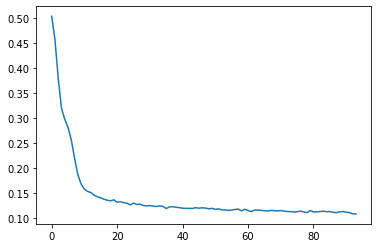

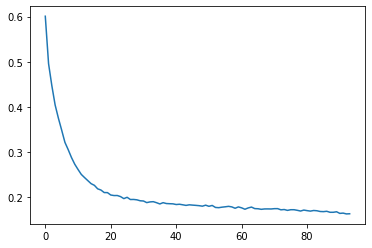

In [252]:
smooth = 100
plt.plot([np.mean(costs[i:i+smooth]) for i, c in enumerate(costs) if i % smooth == 0])
plt.show()
plt.plot([np.mean(losses[i:i+smooth]) for i, c in enumerate(losses) if i % smooth == 0])
plt.show()

In [253]:
# LOAD Validation Samples
data_valid = []
sgs = []
for (a1, a2), v in tqdm(valid_set.items()):
    nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
    sg = g.subgraph(nodes).copy()
    if local_feat:
        for node in sg.nodes():
            nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
            sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
    if add_node:
        sg.add_node('reduce_0', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
        sg.add_node('reduce_1', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
        if single:
            sg.add_edge(a1, 'reduce_0')
            sg.add_edge(a2, 'reduce_0')
            sg.add_edge(a1, 'reduce_1')
            sg.add_edge(a2, 'reduce_1')
        else:
            sg.add_edges_from([[n, 'reduce_0'] for n in sg.nodes()])
            sg.add_edges_from([[n, 'reduce_1'] for n in sg.nodes()])

    sgs.append((sg, a1, a2, p1, p2, b3))
    data = from_networkx(sg, ['feat'])
    data.y = 1.0
    data = T.ToUndirected()(data)
    data = T.AddSelfLoops()(data)
    data.edge_attr = torch.tensor([((data.x[a]+data.x[b])/2).numpy() for a,b in data.edge_index.t()])
    data_valid.append(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.92it/s]


In [254]:
loader_valid = DataLoader(data_valid, batch_size=1)

In [255]:
a = 0
b = 0
net.eval()
pred = {}
for k, batch in zip(valid_set, loader_valid):
  if is_cuda:
    batch = batch.cuda()
  p0, p1 = net(batch)
  pred[k] = p1.item()

In [256]:
def gnn_model(a1, a2, th):
  p = pred[(a1, a2)]
  # print(p, th)
  p = True if p > (1-th) else False
  return p

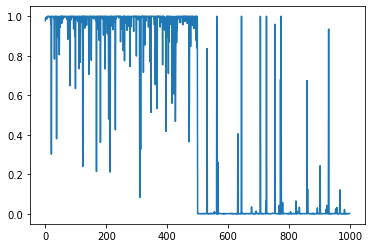

In [257]:
plt.plot(pred.values())

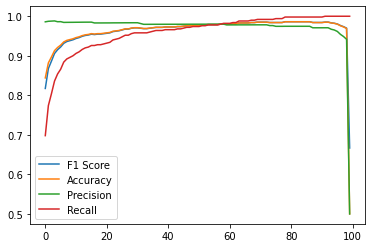

0.9861660079051383 78
0.986 78


In [258]:
plot_one(valid_set, gnn_model)

[2021-12-09 23:59:16,789] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:16,803] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:16,819] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:16,834] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:16,844] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved


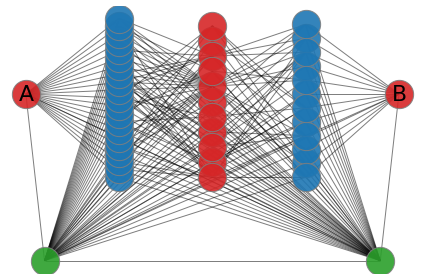

In [268]:
i = 70
draw(*sgs[i])
data_valid[i].ptr = torch.tensor([0, data_valid[i].x.shape[0]]).cuda()

In [269]:
net.eval()
temp = GNN(5, 64, EGATConv).double().cuda()
temp.load_state_dict(net.state_dict())
temp.eval()
res0, res1, a1, a2, a3 = temp(data_valid[i].cuda(), True)

In [270]:
res0.item(), res1.item()

(0.014221388596623207, 0.9856050260777498)

In [271]:
node_id = {i: n for i, n in enumerate(sgs[i][0].nodes())}

In [272]:
data_valid[i].x.shape[0]

48

MIN MAX MEDIAN MEAN STD LEN
0.0016635079508344954 0.3035041128757389 0.09921874744039041 0.10526315789473686 0.08476452808984965 456


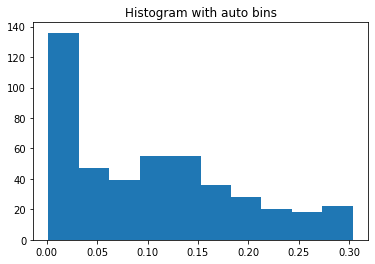

[2021-12-09 23:59:20,612] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:20,651] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:20,683] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:20,740] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:20,768] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved


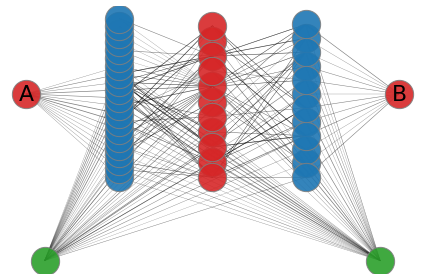

In [273]:
edge_list = [[node_id[e[0]], node_id[e[1]]] for e in a1[0].t().cpu().detach().numpy()]
edge_weight = a1[1].cpu().detach().numpy().reshape(-1)
histogram(edge_weight)
edge_weight = [e for e in edge_weight if e > 0.1]
edge_weight = [w*100 / sum(edge_weight) for w in edge_weight]
draw(*sgs[i], edge_list, edge_weight)

MIN MAX MEDIAN MEAN STD LEN
0.00021959986153401357 0.9972804457773041 0.02556150153503013 0.10526315789473682 0.22850451001336153 456


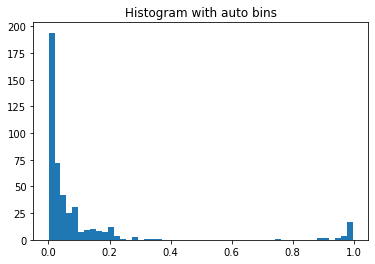

[2021-12-09 23:59:48,570] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:48,587] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:48,604] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:48,624] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:48,635] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved


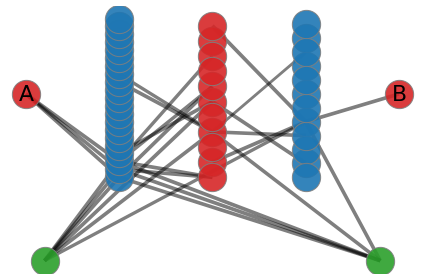

In [277]:
edge_list = [[node_id[e[0]], node_id[e[1]]] for e in a2[0].t().cpu().detach().numpy()]
edge_weight = a2[1].cpu().detach().numpy().reshape(-1)
histogram(edge_weight)
edge_weight = [e for e in edge_weight if e > 0.5]
edge_weight = [w*100 / sum(edge_weight) for w in edge_weight]
draw(*sgs[i], edge_list, edge_weight)

MIN MAX MEDIAN MEAN STD LEN
0.0026827863963625694 0.3333976123936493 0.08470370402570337 0.10526315789473684 0.094588986496669 456


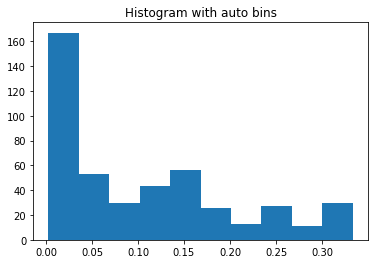

[2021-12-09 23:59:24,795] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:24,831] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:24,863] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:24,922] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved
[2021-12-09 23:59:24,953] [DEBUG] [matplotlib.axes._base]  top of axes not in the figure, so title not moved


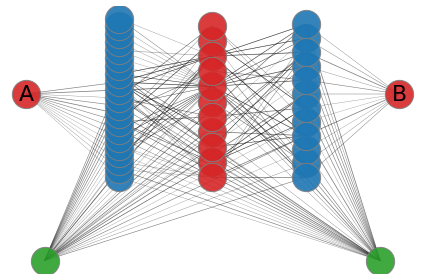

In [275]:
edge_list = [[node_id[e[0]], node_id[e[1]]] for e in a3[0].t().cpu().detach().numpy()]
edge_weight = a3[1].cpu().detach().numpy().reshape(-1)
histogram(edge_weight)
edge_weight = [e for e in edge_weight if e > 0.1]
edge_weight = [w*100 / sum(edge_weight) for w in edge_weight]
draw(*sgs[i], edge_list, edge_weight)

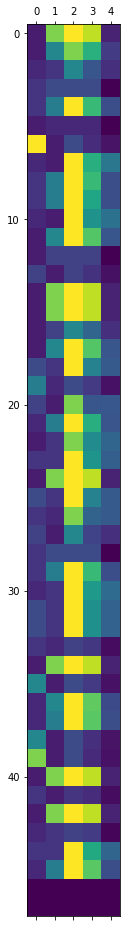

In [276]:
plt.matshow(data_valid[i].x.cpu().detach().numpy())

In [ ]:
a = out2[data_valid[i].x.shape[0] - 1].cpu().detach().numpy()
b1 = temp.classifier.weight.cpu().detach().numpy()[0]
b2 = temp.classifier.bias.cpu().detach().numpy()
c = a * b1
cc = [(i, c[i]) for i in c.argsort() if c[i] > 0.0]
cc

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
f = open('same_author4.csv', 'a')
f.write('ID, ID, label\n')
for i, (a,b) in enumerate(qq_set):
    if pred[(a,b)] > 0.4:
        f.write('{}, {}\n'.format(a, b))
f.close()
print(i)

In [ ]:
authros2candidate, prob = get_candidate(30, 100, 30, 100, 10000)


In [ ]:
aaa = [(c,s[0]) for c, s in authros2candidate.items() if c in all_train and len(s) == 1]
histogram([len(s) for c, s in authros2candidate.items() if c in all_train], bins=[i for i in range(200)])

In [ ]:
aa = {}
same_aa = []
iii = 0
all_train = [a for a,b in train_set]
for aut, cands in tqdm(authros2candidate.items()):
    if aut not in all_train:
        for cand in tqdm(cands):
            if cand not in all_train:
                aa[(aut, cand)] = iii
                iii += 1
                a1, a2 = aut, cand
                nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
                sg = g.subgraph(nodes).copy()
                if local_feat:
                    for node in sg.nodes():
                        nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
                        sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
                if add_node:
                    sg.add_node('reduce', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
                    if single:
                        sg.add_edge(a1, 'reduce')
                        sg.add_edge(a2, 'reduce')
                    else:
                        sg.add_edges_from([[n, 'reduce'] for n in sg.nodes()])
                data = from_networkx(sg, ['feat'])
                data.y = 0.0
                data = T.ToUndirected()(data)
                data = T.AddSelfLoops()(data)
                same_aa.append(data)

In [ ]:
len(same_aa)

In [ ]:
loader_valid = DataLoader(same_aa, batch_size=1)
a = 0
b = 0
net.eval()
pred = {}
for k, batch in zip(tt_set, loader_valid):
  if is_cuda:
    batch = batch.cuda()
  p = net(batch)
  pred[k] = p.item()

In [ ]:
plt.plot(pred.values())

In [ ]:
plot_all(valid_set, [random_model, gnn_model], ['random', 'gnn'])

In [ ]:
tt_set = {(a[0], a[1]): True for a in train_set}
data_valid2 = []
for (a1, a2), v in tqdm(qq_set.items()):
    nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
    sg = g.subgraph(nodes).copy()
    if local_feat:
        for node in sg.nodes():
            nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
            sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
    if add_node:
        sg.add_node('reduce', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
        if single:
            sg.add_edge(a1, 'reduce')
            sg.add_edge(a2, 'reduce')
        else:
            sg.add_edges_from([[n, 'reduce'] for n in sg.nodes()])
    data = from_networkx(sg, ['feat'])
    data.y = 1.0
    data = T.ToUndirected()(data)
    data = T.AddSelfLoops()(data)
    data_valid2.append(data)

In [ ]:
loader_valid = DataLoader(data_valid, batch_size=1)
a = 0
b = 0
net.eval()
pred = {}
for k, batch in zip(tt_set, loader_valid):
  if is_cuda:
    batch = batch.cuda()
  p = net(batch)
  pred[k] = p.item()

In [ ]:
plot_one(tt_set, gnn_model)

In [ ]:
plot_all(tt_set, [random_model, gnn_model], ['random', 'gnn'])

In [ ]:
valid2_set = {}
for k,v in tt_set.items():
    valid2_set[k] = v

In [ ]:


authros2candidate, prob = get_candidate(20, 50, 20, 50, 2000)
for i in tqdm(range(1)):
    for aut, cand in authros2candidate.items():
        a1, a2 = aut, np.random.choice(cand)
        valid2_set[(a1, a2)] = False
        nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
        sg = g.subgraph(nodes).copy()
        if local_feat:
            for node in sg.nodes():
                nbs_degree = [sg.degree[nb] for nb in sg.adj[node]]
                sg.nodes[node]['feat'] = [sg.degree(node), np.min(nbs_degree), np.max(nbs_degree), np.mean(nbs_degree), np.std(nbs_degree)]
        if add_node:
            sg.add_node('reduce', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
            if single:
                sg.add_edge(a1, 'reduce')
                sg.add_edge(a2, 'reduce')
            else:
                sg.add_edges_from([[n, 'reduce'] for n in sg.nodes()])
        data = from_networkx(sg, ['feat'])
        data.y = 0.0
        data = T.ToUndirected()(data)
        data = T.AddSelfLoops()(data)
        data_valid2.append(data)

# LOAD Negetive Samples (Same Paper)
# data_valid2 = []
# for _ in tqdm(range(2000)):
# #   a1, a2 = aut, np.random.choice(cand)
#   a1, a2 = np.random.choice(list(author2paper), 2, replace=False)
#   valid2_set[(a1, a2)] = False
#   nodes, a1, a2, p1, p2, b3 = get_subgraph(a1, a2, 3)
#   sg = g.subgraph(nodes).copy()
#   if add_node:
#     sg.add_node('reduce', feat=[0.0, 0.0, 0.0, 0.0, 0.0])
#     if single:
#       sg.add_edge(a1, 'reduce')
#       sg.add_edge(a2, 'reduce')
#     else:
#       sg.add_edges_from([[n, 'reduce'] for n in sg.nodes()])
#   data = from_networkx(sg, ['feat'])
#   data.y = 0.0
#   data = T.ToUndirected()(data)
#   data = T.AddSelfLoops()(data)
#   data_valid2.append(data)

net.eval()
pred = {}
loader_valid2 = DataLoader(data_valid2, batch_size=1)
for k, batch in zip(valid2_set, loader_valid2):
  if is_cuda:
    batch = batch.cuda()
  p = net(batch)
  pred[k] = p.item()

In [ ]:
net.eval()
pred = {}
loader_valid2 = DataLoader(data_valid2, batch_size=1)
for k, batch in zip(valid2_set, loader_valid2):
  if is_cuda:
    batch = batch.cuda()
  p = net(batch)
  pred[k] = p.item()

In [ ]:
plot_one(valid2_set, gnn_model)
plot_all(valid2_set, [random_model, gnn_model], ['random', 'gnn'])

In [ ]:
sum(pred.values()), sum(valid2_set.values()), len(pred)

In [ ]:
nodes, a1, a2, p1, p2, b3 = get_subgraph(1731909, 2181304, 3)
sg = g.subgraph(nodes)
draw(sg, a1, a2, p1, p2, b3)

In [ ]:
plt.plot(pred.values())